# Stock value prediction from Open, High, Low

# Import module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py

Using TensorFlow backend.


# Input parameters 

In [2]:
stock_name = '^GSPC'
seq_len = 22
d = 0.2
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

# 1. Download data and normalize it
Data since 1950 to today

In [3]:
def get_stock_data(stock_name, normalize=True):
    start = datetime.datetime(1950, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    df.drop(['Volume', 'Close'], 1, inplace=True)
    
    if normalize:        
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    return df

df = get_stock_data(stock_name, normalize=True)

# 2. Plot out the Normalized Adjusted close price

                Open      High       Low  Adj Close
Date                                               
1950-01-03  0.000000  0.000000  0.000000   0.000000
1950-01-04  0.000080  0.000080  0.000080   0.000080
1950-01-05  0.000114  0.000113  0.000114   0.000113
1950-01-06  0.000135  0.000134  0.000135   0.000134
1950-01-09  0.000177  0.000176  0.000177   0.000177


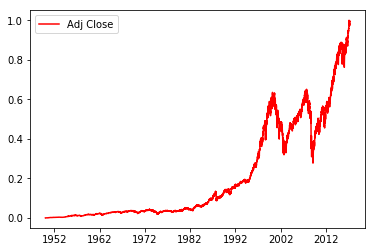

In [4]:
def plot_stock(stock_name):
    df = get_stock_data(stock_name, normalize=True)
    print(df.head())
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.show()

plot_stock(stock_name)

# 3. Set last day Adjusted Close as y

In [5]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features # (3893, 23, 4)
    X_train = train[:, :-1] # x = all feature except adj close # (3893, 22, 4)
    y_train = train[:, -1][:,-1] # y = last feature, last day (3893)
    X_test = result[int(row):, :-1] #(432, 22, 4)
    y_test = result[int(row):, -1][:,-1] #(432)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

X_train, y_train, X_test, y_test = load_data(df, seq_len)

# 4. Buidling neural network

In [6]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    # adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# 6. Model Execution

In [7]:
model = build_model2(shape, neurons, d)
# layers = [4, 22, 1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)

Train on 13702 samples, validate on 1523 samples
Epoch 1/300
13702/13702 [==============================] - 3s - loss: 0.0130 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 2/300
13702/13702 [==============================] - 1s - loss: 5.7921e-04 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 3/300
13702/13702 [==============================] - 1s - loss: 2.2940e-04 - acc: 0.0000e+00 - val_loss: 5.9576e-04 - val_acc: 0.0000e+00
Epoch 4/300
13702/13702 [==============================] - 1s - loss: 1.7692e-04 - acc: 0.0000e+00 - val_loss: 3.0269e-04 - val_acc: 0.0000e+00
Epoch 5/300
13702/13702 [==============================] - 1s - loss: 1.4230e-04 - acc: 0.0000e+00 - val_loss: 2.9065e-04 - val_acc: 0.0000e+00
Epoch 6/300
13702/13702 [==============================] - 1s - loss: 1.3714e-04 - acc: 0.0000e+00 - val_loss: 2.4568e-04 - val_acc: 0.0000e+00
Epoch 7/300
13702/13702 [==============================] - 1s - loss: 1.3422e-04 - acc: 0.0000e+00 

13702/13702 [==============================] - 1s - loss: 8.3772e-05 - acc: 0.0000e+00 - val_loss: 1.4060e-04 - val_acc: 0.0000e+00
Epoch 58/300
13702/13702 [==============================] - 1s - loss: 8.1133e-05 - acc: 0.0000e+00 - val_loss: 1.3583e-04 - val_acc: 0.0000e+00
Epoch 59/300
13702/13702 [==============================] - 1s - loss: 8.0573e-05 - acc: 0.0000e+00 - val_loss: 1.5716e-04 - val_acc: 0.0000e+00
Epoch 60/300
13702/13702 [==============================] - 1s - loss: 8.8464e-05 - acc: 0.0000e+00 - val_loss: 1.4628e-04 - val_acc: 0.0000e+00
Epoch 61/300
13702/13702 [==============================] - 1s - loss: 7.9502e-05 - acc: 0.0000e+00 - val_loss: 1.4117e-04 - val_acc: 0.0000e+00
Epoch 62/300
13702/13702 [==============================] - 1s - loss: 7.2881e-05 - acc: 0.0000e+00 - val_loss: 1.7660e-04 - val_acc: 0.0000e+00
Epoch 63/300
13702/13702 [==============================] - 1s - loss: 9.0473e-05 - acc: 0.0000e+00 - val_loss: 1.8386e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 6.0211e-05 - acc: 0.0000e+00 - val_loss: 1.0010e-04 - val_acc: 0.0000e+00
Epoch 114/300
13702/13702 [==============================] - 1s - loss: 6.2194e-05 - acc: 0.0000e+00 - val_loss: 1.3731e-04 - val_acc: 0.0000e+00
Epoch 115/300
13702/13702 [==============================] - 1s - loss: 6.7334e-05 - acc: 0.0000e+00 - val_loss: 1.0991e-04 - val_acc: 0.0000e+00
Epoch 116/300
13702/13702 [==============================] - 1s - loss: 5.9973e-05 - acc: 0.0000e+00 - val_loss: 1.3664e-04 - val_acc: 0.0000e+00
Epoch 117/300
13702/13702 [==============================] - 1s - loss: 5.8771e-05 - acc: 0.0000e+00 - val_loss: 1.6268e-04 - val_acc: 0.0000e+00
Epoch 118/300
13702/13702 [==============================] - 1s - loss: 5.7709e-05 - acc: 0.0000e+00 - val_loss: 1.0235e-04 - val_acc: 0.0000e+00
Epoch 119/300
13702/13702 [==============================] - 1s - loss: 6.0638e-05 - acc: 0.0000e+00 - val_loss: 1.1436e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 4.8185e-05 - acc: 0.0000e+00 - val_loss: 2.2663e-04 - val_acc: 0.0000e+00
Epoch 170/300
13702/13702 [==============================] - 1s - loss: 4.8228e-05 - acc: 0.0000e+00 - val_loss: 3.0901e-04 - val_acc: 0.0000e+00
Epoch 171/300
13702/13702 [==============================] - 1s - loss: 4.1897e-05 - acc: 0.0000e+00 - val_loss: 2.9126e-04 - val_acc: 0.0000e+00
Epoch 172/300
13702/13702 [==============================] - 1s - loss: 4.0866e-05 - acc: 0.0000e+00 - val_loss: 1.1514e-04 - val_acc: 0.0000e+00
Epoch 173/300
13702/13702 [==============================] - 1s - loss: 4.3793e-05 - acc: 0.0000e+00 - val_loss: 1.7363e-04 - val_acc: 0.0000e+00
Epoch 174/300
13702/13702 [==============================] - 1s - loss: 4.1790e-05 - acc: 0.0000e+00 - val_loss: 5.5395e-04 - val_acc: 0.0000e+00
Epoch 175/300
13702/13702 [==============================] - 1s - loss: 4.3867e-05 - acc: 0.0000e+00 - val_loss: 2.4929e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 3.0495e-05 - acc: 0.0000e+00 - val_loss: 4.8506e-04 - val_acc: 0.0000e+00
Epoch 226/300
13702/13702 [==============================] - 1s - loss: 3.5883e-05 - acc: 0.0000e+00 - val_loss: 1.6562e-04 - val_acc: 0.0000e+00
Epoch 227/300
13702/13702 [==============================] - 1s - loss: 3.2214e-05 - acc: 0.0000e+00 - val_loss: 1.5212e-04 - val_acc: 0.0000e+00
Epoch 228/300
13702/13702 [==============================] - 1s - loss: 3.7523e-05 - acc: 0.0000e+00 - val_loss: 3.9378e-04 - val_acc: 0.0000e+00
Epoch 229/300
13702/13702 [==============================] - 1s - loss: 3.4607e-05 - acc: 0.0000e+00 - val_loss: 2.2095e-04 - val_acc: 0.0000e+00
Epoch 230/300
13702/13702 [==============================] - 1s - loss: 3.5695e-05 - acc: 0.0000e+00 - val_loss: 4.2015e-04 - val_acc: 0.0000e+00
Epoch 231/300
13702/13702 [==============================] - 1s - loss: 3.6460e-05 - acc: 0.0000e+00 - val_loss: 3.8949e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 2.7226e-05 - acc: 0.0000e+00 - val_loss: 6.1144e-04 - val_acc: 0.0000e+00
Epoch 282/300
13702/13702 [==============================] - 1s - loss: 3.1688e-05 - acc: 0.0000e+00 - val_loss: 4.2847e-04 - val_acc: 0.0000e+00
Epoch 283/300
13702/13702 [==============================] - 1s - loss: 2.7638e-05 - acc: 0.0000e+00 - val_loss: 2.5996e-04 - val_acc: 0.0000e+00
Epoch 284/300
13702/13702 [==============================] - 1s - loss: 2.6441e-05 - acc: 0.0000e+00 - val_loss: 3.5505e-04 - val_acc: 0.0000e+00
Epoch 285/300
13702/13702 [==============================] - 1s - loss: 3.0080e-05 - acc: 0.0000e+00 - val_loss: 3.7260e-04 - val_acc: 0.0000e+00
Epoch 286/300
13702/13702 [==============================] - 1s - loss: 3.2873e-05 - acc: 0.0000e+00 - val_loss: 6.3146e-04 - val_acc: 0.0000e+00
Epoch 287/300
13702/13702 [==============================] - 1s - loss: 2.8216e-05 - acc: 0.0000e+00 - val_loss: 5.3382e-04 - val_acc: 0.0

# 7. Result on training set and testing set

In [9]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]
    
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00010 MSE (0.01 RMSE)
Test Score: 0.00036 MSE (0.02 RMSE)


(0.00010174956262023349, 0.0003598967045074963)

# 8. Prediction vs Real results

In [10]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

p = percentage_difference(model, X_test, y_test)

# 9. Plot out prediction

In [11]:
def denormalize(stock_name, normalized_value):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

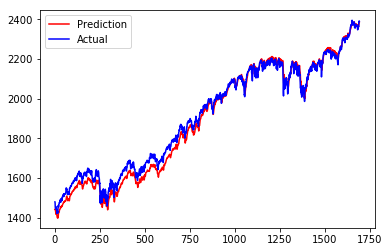

In [12]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.show()
    
plot_result(stock_name, p, y_test)

# 10. Save for consistency

In [13]:
model.save('LSTM_Stock_prediction-20170429.h5')

# Part 2. Fine tune model
# 11. Function to load data, train model and see score

In [14]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

In [15]:
def quick_measure(stock_name, seq_len, d, shape, neurons, epochs):
    df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model2(shape, neurons, d)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

# 12. Fine tune hyperparameter

12.1 Optimial Dropout value

In [23]:
dlist = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
neurons_LSTM = [32, 64, 128, 256, 512, 1024, 2048]
dropout_result = {}

for d in dlist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
    dropout_result[d] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_17 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________
Trai

13702/13702 [==============================] - 1s - loss: 8.1249e-05 - acc: 0.0000e+00 - val_loss: 1.6803e-04 - val_acc: 0.0000e+00
Epoch 50/300
13702/13702 [==============================] - 1s - loss: 9.1792e-05 - acc: 0.0000e+00 - val_loss: 4.1523e-04 - val_acc: 0.0000e+00
Epoch 51/300
13702/13702 [==============================] - 1s - loss: 9.8591e-05 - acc: 0.0000e+00 - val_loss: 1.4510e-04 - val_acc: 0.0000e+00
Epoch 52/300
13702/13702 [==============================] - 1s - loss: 1.0371e-04 - acc: 0.0000e+00 - val_loss: 1.5422e-04 - val_acc: 0.0000e+00
Epoch 53/300
13702/13702 [==============================] - 1s - loss: 8.6938e-05 - acc: 0.0000e+00 - val_loss: 2.7897e-04 - val_acc: 0.0000e+00
Epoch 54/300
13702/13702 [==============================] - 1s - loss: 9.1394e-05 - acc: 0.0000e+00 - val_loss: 1.8889e-04 - val_acc: 0.0000e+00
Epoch 55/300
13702/13702 [==============================] - 1s - loss: 8.7931e-05 - acc: 0.0000e+00 - val_loss: 1.3869e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 6.1786e-05 - acc: 0.0000e+00 - val_loss: 2.3667e-04 - val_acc: 0.0000e+00
Epoch 106/300
13702/13702 [==============================] - 1s - loss: 6.4980e-05 - acc: 0.0000e+00 - val_loss: 1.2261e-04 - val_acc: 0.0000e+00
Epoch 107/300
13702/13702 [==============================] - 1s - loss: 6.8195e-05 - acc: 0.0000e+00 - val_loss: 1.3106e-04 - val_acc: 0.0000e+00
Epoch 108/300
13702/13702 [==============================] - 1s - loss: 6.2237e-05 - acc: 0.0000e+00 - val_loss: 1.2377e-04 - val_acc: 0.0000e+00
Epoch 109/300
13702/13702 [==============================] - 1s - loss: 6.1468e-05 - acc: 0.0000e+00 - val_loss: 1.0991e-04 - val_acc: 0.0000e+00
Epoch 110/300
13702/13702 [==============================] - 1s - loss: 6.7530e-05 - acc: 0.0000e+00 - val_loss: 1.1433e-04 - val_acc: 0.0000e+00
Epoch 111/300
13702/13702 [==============================] - 1s - loss: 6.1319e-05 - acc: 0.0000e+00 - val_loss: 9.6058e-05 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 4.3952e-05 - acc: 0.0000e+00 - val_loss: 8.8537e-05 - val_acc: 0.0000e+00
Epoch 162/300
13702/13702 [==============================] - 1s - loss: 4.4084e-05 - acc: 0.0000e+00 - val_loss: 9.0497e-05 - val_acc: 0.0000e+00
Epoch 163/300
13702/13702 [==============================] - 1s - loss: 5.0225e-05 - acc: 0.0000e+00 - val_loss: 8.4298e-05 - val_acc: 0.0000e+00
Epoch 164/300
13702/13702 [==============================] - 1s - loss: 4.6301e-05 - acc: 0.0000e+00 - val_loss: 1.5655e-04 - val_acc: 0.0000e+00
Epoch 165/300
13702/13702 [==============================] - 1s - loss: 5.1345e-05 - acc: 0.0000e+00 - val_loss: 8.2517e-05 - val_acc: 0.0000e+00
Epoch 166/300
13702/13702 [==============================] - 1s - loss: 4.9469e-05 - acc: 0.0000e+00 - val_loss: 1.1771e-04 - val_acc: 0.0000e+00
Epoch 167/300
13702/13702 [==============================] - 1s - loss: 5.0253e-05 - acc: 0.0000e+00 - val_loss: 7.3709e-05 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 3.9481e-05 - acc: 0.0000e+00 - val_loss: 8.4440e-05 - val_acc: 0.0000e+00
Epoch 218/300
13702/13702 [==============================] - 1s - loss: 3.7271e-05 - acc: 0.0000e+00 - val_loss: 7.6987e-05 - val_acc: 0.0000e+00
Epoch 219/300
13702/13702 [==============================] - 1s - loss: 3.8756e-05 - acc: 0.0000e+00 - val_loss: 7.4955e-05 - val_acc: 0.0000e+00
Epoch 220/300
13702/13702 [==============================] - 1s - loss: 3.6757e-05 - acc: 0.0000e+00 - val_loss: 7.2061e-05 - val_acc: 0.0000e+00
Epoch 221/300
13702/13702 [==============================] - 1s - loss: 3.7897e-05 - acc: 0.0000e+00 - val_loss: 8.6368e-05 - val_acc: 0.0000e+00
Epoch 222/300
13702/13702 [==============================] - 1s - loss: 4.0011e-05 - acc: 0.0000e+00 - val_loss: 6.7412e-05 - val_acc: 0.0000e+00
Epoch 223/300
13702/13702 [==============================] - 1s - loss: 3.6490e-05 - acc: 0.0000e+00 - val_loss: 1.0807e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 3.4690e-05 - acc: 0.0000e+00 - val_loss: 6.1618e-05 - val_acc: 0.0000e+00
Epoch 274/300
13702/13702 [==============================] - 1s - loss: 3.1589e-05 - acc: 0.0000e+00 - val_loss: 6.4427e-05 - val_acc: 0.0000e+00
Epoch 275/300
13702/13702 [==============================] - 1s - loss: 3.5297e-05 - acc: 0.0000e+00 - val_loss: 5.9463e-05 - val_acc: 0.0000e+00
Epoch 276/300
13702/13702 [==============================] - 1s - loss: 3.1783e-05 - acc: 0.0000e+00 - val_loss: 7.4361e-05 - val_acc: 0.0000e+00
Epoch 277/300
13702/13702 [==============================] - 1s - loss: 3.4933e-05 - acc: 0.0000e+00 - val_loss: 9.4194e-05 - val_acc: 0.0000e+00
Epoch 278/300
13702/13702 [==============================] - 1s - loss: 3.2558e-05 - acc: 0.0000e+00 - val_loss: 6.1318e-05 - val_acc: 0.0000e+00
Epoch 279/300
13702/13702 [==============================] - 1s - loss: 3.8294e-05 - acc: 0.0000e+00 - val_loss: 8.8355e-05 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 1.5562e-04 - acc: 0.0000e+00 - val_loss: 6.4125e-04 - val_acc: 0.0000e+00
Epoch 21/300
13702/13702 [==============================] - 1s - loss: 1.6698e-04 - acc: 0.0000e+00 - val_loss: 3.1872e-04 - val_acc: 0.0000e+00
Epoch 22/300
13702/13702 [==============================] - 1s - loss: 1.7413e-04 - acc: 0.0000e+00 - val_loss: 3.2942e-04 - val_acc: 0.0000e+00
Epoch 23/300
13702/13702 [==============================] - 1s - loss: 1.4956e-04 - acc: 0.0000e+00 - val_loss: 2.0891e-04 - val_acc: 0.0000e+00
Epoch 24/300
13702/13702 [==============================] - 1s - loss: 1.5216e-04 - acc: 0.0000e+00 - val_loss: 5.3458e-04 - val_acc: 0.0000e+00
Epoch 25/300
13702/13702 [==============================] - 1s - loss: 1.4924e-04 - acc: 0.0000e+00 - val_loss: 1.9061e-04 - val_acc: 0.0000e+00
Epoch 26/300
13702/13702 [==============================] - 1s - loss: 1.5519e-04 - acc: 0.0000e+00 - val_loss: 3.3778e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 9.9489e-05 - acc: 0.0000e+00 - val_loss: 1.5120e-04 - val_acc: 0.0000e+0000e
Epoch 77/300
13702/13702 [==============================] - 1s - loss: 9.4651e-05 - acc: 0.0000e+00 - val_loss: 1.7162e-04 - val_acc: 0.0000e+00
Epoch 78/300
13702/13702 [==============================] - 1s - loss: 9.6063e-05 - acc: 0.0000e+00 - val_loss: 1.5722e-04 - val_acc: 0.0000e+00
Epoch 79/300
13702/13702 [==============================] - 1s - loss: 1.0355e-04 - acc: 0.0000e+00 - val_loss: 1.2651e-04 - val_acc: 0.0000e+0000e
Epoch 80/300
13702/13702 [==============================] - 1s - loss: 9.6740e-05 - acc: 0.0000e+00 - val_loss: 1.9936e-04 - val_acc: 0.0000e+00
Epoch 81/300
13702/13702 [==============================] - 1s - loss: 9.6821e-05 - acc: 0.0000e+00 - val_loss: 3.3484e-04 - val_acc: 0.0000e+00
Epoch 82/300
13702/13702 [==============================] - 1s - loss: 1.0375e-04 - acc: 0.0000e+00 - val_loss: 1.2630e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 6.3433e-05 - acc: 0.0000e+00 - val_loss: 2.7105e-04 - val_acc: 0.0000e+00
Epoch 133/300
13702/13702 [==============================] - 1s - loss: 7.4739e-05 - acc: 0.0000e+00 - val_loss: 2.7288e-04 - val_acc: 0.0000e+00
Epoch 134/300
13702/13702 [==============================] - 1s - loss: 6.7838e-05 - acc: 0.0000e+00 - val_loss: 1.0321e-04 - val_acc: 0.0000e+00
Epoch 135/300
13702/13702 [==============================] - 1s - loss: 6.9862e-05 - acc: 0.0000e+00 - val_loss: 1.3938e-04 - val_acc: 0.0000e+00
Epoch 136/300
13702/13702 [==============================] - 1s - loss: 7.9317e-05 - acc: 0.0000e+00 - val_loss: 1.3731e-04 - val_acc: 0.0000e+00
Epoch 137/300
13702/13702 [==============================] - 1s - loss: 7.0154e-05 - acc: 0.0000e+00 - val_loss: 1.9247e-04 - val_acc: 0.0000e+00
Epoch 138/300
13702/13702 [==============================] - 1s - loss: 6.4486e-05 - acc: 0.0000e+00 - val_loss: 1.5125e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 5.0599e-05 - acc: 0.0000e+00 - val_loss: 1.2909e-04 - val_acc: 0.0000e+00
Epoch 188/300
13702/13702 [==============================] - 1s - loss: 5.0851e-05 - acc: 0.0000e+00 - val_loss: 1.1446e-04 - val_acc: 0.0000e+00
Epoch 189/300
13702/13702 [==============================] - 1s - loss: 5.2853e-05 - acc: 0.0000e+00 - val_loss: 1.2426e-04 - val_acc: 0.0000e+00
Epoch 190/300
13702/13702 [==============================] - 1s - loss: 4.9944e-05 - acc: 0.0000e+00 - val_loss: 1.5018e-04 - val_acc: 0.0000e+00
Epoch 191/300
13702/13702 [==============================] - 1s - loss: 5.1618e-05 - acc: 0.0000e+00 - val_loss: 1.7918e-04 - val_acc: 0.0000e+00
Epoch 192/300
13702/13702 [==============================] - 1s - loss: 5.4237e-05 - acc: 0.0000e+00 - val_loss: 1.4274e-04 - val_acc: 0.0000e+00
Epoch 193/300
13702/13702 [==============================] - 1s - loss: 4.6970e-05 - acc: 0.0000e+00 - val_loss: 1.9071e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 3.9698e-05 - acc: 0.0000e+00 - val_loss: 8.6679e-04 - val_acc: 0.0000e+00
Epoch 244/300
13702/13702 [==============================] - 1s - loss: 4.0289e-05 - acc: 0.0000e+00 - val_loss: 6.7704e-04 - val_acc: 0.0000e+00
Epoch 245/300
13702/13702 [==============================] - 1s - loss: 4.5648e-05 - acc: 0.0000e+00 - val_loss: 5.4294e-04 - val_acc: 0.0000e+00
Epoch 246/300
13702/13702 [==============================] - 1s - loss: 4.4502e-05 - acc: 0.0000e+00 - val_loss: 3.3888e-04 - val_acc: 0.0000e+00
Epoch 247/300
13702/13702 [==============================] - 1s - loss: 4.0186e-05 - acc: 0.0000e+00 - val_loss: 3.5092e-04 - val_acc: 0.0000e+00
Epoch 248/300
13702/13702 [==============================] - 1s - loss: 4.7147e-05 - acc: 0.0000e+00 - val_loss: 4.3610e-04 - val_acc: 0.0000e+00
Epoch 249/300
13702/13702 [==============================] - 1s - loss: 3.8760e-05 - acc: 0.0000e+00 - val_loss: 6.7867e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 3.6802e-05 - acc: 0.0000e+00 - val_loss: 8.9757e-04 - val_acc: 0.0000e+00
Epoch 300/300
13702/13702 [==============================] - 1s - loss: 3.4732e-05 - acc: 0.0000e+00 - val_loss: 6.4950e-04 - val_acc: 0.0000e+00
Train Score: 0.00013 MSE (0.01 RMSE)
Test Score: 0.00223 MSE (0.05 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_21 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_______________________________________________________

13702/13702 [==============================] - 1s - loss: 1.8026e-04 - acc: 0.0000e+00 - val_loss: 2.4794e-04 - val_acc: 0.0000e+00
Epoch 48/300
13702/13702 [==============================] - 1s - loss: 1.7000e-04 - acc: 0.0000e+00 - val_loss: 3.5737e-04 - val_acc: 0.0000e+00
Epoch 49/300
13702/13702 [==============================] - 1s - loss: 1.6763e-04 - acc: 0.0000e+00 - val_loss: 1.6839e-04 - val_acc: 0.0000e+00
Epoch 50/300
13702/13702 [==============================] - 1s - loss: 1.5622e-04 - acc: 0.0000e+00 - val_loss: 1.7348e-04 - val_acc: 0.0000e+00
Epoch 51/300
13702/13702 [==============================] - 1s - loss: 1.5985e-04 - acc: 0.0000e+00 - val_loss: 1.6267e-04 - val_acc: 0.0000e+00
Epoch 52/300
13702/13702 [==============================] - 1s - loss: 1.6144e-04 - acc: 0.0000e+00 - val_loss: 3.1402e-04 - val_acc: 0.0000e+00
Epoch 53/300
13702/13702 [==============================] - 1s - loss: 1.7031e-04 - acc: 0.0000e+00 - val_loss: 8.4756e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 1.0039e-04 - acc: 0.0000e+00 - val_loss: 1.4698e-04 - val_acc: 0.0000e+00
Epoch 104/300
13702/13702 [==============================] - 1s - loss: 8.6438e-05 - acc: 0.0000e+00 - val_loss: 2.8614e-04 - val_acc: 0.0000e+00
Epoch 105/300
13702/13702 [==============================] - 1s - loss: 1.0214e-04 - acc: 0.0000e+00 - val_loss: 1.2785e-04 - val_acc: 0.0000e+00
Epoch 106/300
13702/13702 [==============================] - 1s - loss: 8.3759e-05 - acc: 0.0000e+00 - val_loss: 1.7592e-04 - val_acc: 0.0000e+00
Epoch 107/300
13702/13702 [==============================] - 1s - loss: 8.7740e-05 - acc: 0.0000e+00 - val_loss: 1.8724e-04 - val_acc: 0.0000e+00
Epoch 108/300
13702/13702 [==============================] - 1s - loss: 8.6387e-05 - acc: 0.0000e+00 - val_loss: 1.3339e-04 - val_acc: 0.0000e+00
Epoch 109/300
13702/13702 [==============================] - 1s - loss: 9.2106e-05 - acc: 0.0000e+00 - val_loss: 3.1184e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 7.1296e-05 - acc: 0.0000e+00 - val_loss: 1.4057e-04 - val_acc: 0.0000e+00
Epoch 160/300
13702/13702 [==============================] - 1s - loss: 6.1691e-05 - acc: 0.0000e+00 - val_loss: 1.1298e-04 - val_acc: 0.0000e+00
Epoch 161/300
13702/13702 [==============================] - 1s - loss: 6.9301e-05 - acc: 0.0000e+00 - val_loss: 1.1585e-04 - val_acc: 0.0000e+00
Epoch 162/300
13702/13702 [==============================] - 1s - loss: 6.4087e-05 - acc: 0.0000e+00 - val_loss: 1.5222e-04 - val_acc: 0.0000e+00
Epoch 163/300
13702/13702 [==============================] - 1s - loss: 6.3793e-05 - acc: 0.0000e+00 - val_loss: 1.7010e-04 - val_acc: 0.0000e+00
Epoch 164/300
13702/13702 [==============================] - 1s - loss: 6.8608e-05 - acc: 0.0000e+00 - val_loss: 3.1628e-04 - val_acc: 0.0000e+00
Epoch 165/300
13702/13702 [==============================] - 1s - loss: 7.0132e-05 - acc: 0.0000e+00 - val_loss: 1.1609e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 5.7925e-05 - acc: 0.0000e+00 - val_loss: 1.5510e-04 - val_acc: 0.0000e+00
Epoch 216/300
13702/13702 [==============================] - 1s - loss: 6.1216e-05 - acc: 0.0000e+00 - val_loss: 1.9629e-04 - val_acc: 0.0000e+00
Epoch 217/300
13702/13702 [==============================] - 1s - loss: 5.7475e-05 - acc: 0.0000e+00 - val_loss: 1.0115e-04 - val_acc: 0.0000e+00
Epoch 218/300
13702/13702 [==============================] - 1s - loss: 5.1581e-05 - acc: 0.0000e+00 - val_loss: 1.1191e-04 - val_acc: 0.0000e+00
Epoch 219/300
13702/13702 [==============================] - 1s - loss: 5.4284e-05 - acc: 0.0000e+00 - val_loss: 1.0124e-04 - val_acc: 0.0000e+00
Epoch 220/300
13702/13702 [==============================] - 1s - loss: 5.7498e-05 - acc: 0.0000e+00 - val_loss: 1.1479e-04 - val_acc: 0.0000e+00
Epoch 221/300
13702/13702 [==============================] - 1s - loss: 5.8663e-05 - acc: 0.0000e+00 - val_loss: 1.7664e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 4.9399e-05 - acc: 0.0000e+00 - val_loss: 1.0380e-04 - val_acc: 0.0000e+00
Epoch 272/300
13702/13702 [==============================] - 1s - loss: 5.3103e-05 - acc: 0.0000e+00 - val_loss: 1.4977e-04 - val_acc: 0.0000e+00
Epoch 273/300
13702/13702 [==============================] - 1s - loss: 5.3189e-05 - acc: 0.0000e+00 - val_loss: 1.3721e-04 - val_acc: 0.0000e+00
Epoch 274/300
13702/13702 [==============================] - 1s - loss: 5.2630e-05 - acc: 0.0000e+00 - val_loss: 1.1542e-04 - val_acc: 0.0000e+00
Epoch 275/300
13702/13702 [==============================] - 1s - loss: 4.9756e-05 - acc: 0.0000e+00 - val_loss: 9.4683e-05 - val_acc: 0.0000e+00
Epoch 276/300
13702/13702 [==============================] - 1s - loss: 4.7233e-05 - acc: 0.0000e+00 - val_loss: 9.0343e-05 - val_acc: 0.0000e+00
Epoch 277/300
13702/13702 [==============================] - 1s - loss: 4.5547e-05 - acc: 0.0000e+00 - val_loss: 9.0549e-05 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 2.7987e-04 - acc: 0.0000e+00 - val_loss: 6.8535e-04 - val_acc: 0.0000e+00
Epoch 19/300
13702/13702 [==============================] - 1s - loss: 2.8777e-04 - acc: 0.0000e+00 - val_loss: 5.7020e-04 - val_acc: 0.0000e+00
Epoch 20/300
13702/13702 [==============================] - 1s - loss: 2.7076e-04 - acc: 0.0000e+00 - val_loss: 2.5843e-04 - val_acc: 0.0000e+00
Epoch 21/300
13702/13702 [==============================] - 1s - loss: 3.2128e-04 - acc: 0.0000e+00 - val_loss: 2.6402e-04 - val_acc: 0.0000e+00
Epoch 22/300
13702/13702 [==============================] - 1s - loss: 2.7462e-04 - acc: 0.0000e+00 - val_loss: 2.2810e-04 - val_acc: 0.0000e+00
Epoch 23/300
13702/13702 [==============================] - 1s - loss: 2.6210e-04 - acc: 0.0000e+00 - val_loss: 3.5313e-04 - val_acc: 0.0000e+00
Epoch 24/300
13702/13702 [==============================] - 1s - loss: 2.6585e-04 - acc: 0.0000e+00 - val_loss: 2.4631e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 1.2303e-04 - acc: 0.0000e+00 - val_loss: 1.8200e-04 - val_acc: 0.0000e+00
Epoch 75/300
13702/13702 [==============================] - 1s - loss: 1.1591e-04 - acc: 0.0000e+00 - val_loss: 1.8617e-04 - val_acc: 0.0000e+00
Epoch 76/300
13702/13702 [==============================] - 1s - loss: 1.2509e-04 - acc: 0.0000e+00 - val_loss: 1.7907e-04 - val_acc: 0.0000e+00
Epoch 77/300
13702/13702 [==============================] - 1s - loss: 1.1656e-04 - acc: 0.0000e+00 - val_loss: 4.6717e-04 - val_acc: 0.0000e+00
Epoch 78/300
13702/13702 [==============================] - 1s - loss: 1.1367e-04 - acc: 0.0000e+00 - val_loss: 1.9309e-04 - val_acc: 0.0000e+00
Epoch 79/300
13702/13702 [==============================] - 1s - loss: 1.1463e-04 - acc: 0.0000e+00 - val_loss: 3.0223e-04 - val_acc: 0.0000e+00
Epoch 80/300
13702/13702 [==============================] - 1s - loss: 1.4130e-04 - acc: 0.0000e+00 - val_loss: 4.0616e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 7.7305e-05 - acc: 0.0000e+00 - val_loss: 1.5108e-04 - val_acc: 0.0000e+00
Epoch 131/300
13702/13702 [==============================] - 1s - loss: 8.4592e-05 - acc: 0.0000e+00 - val_loss: 2.5204e-04 - val_acc: 0.0000e+00
Epoch 132/300
13702/13702 [==============================] - 1s - loss: 7.9475e-05 - acc: 0.0000e+00 - val_loss: 2.6891e-04 - val_acc: 0.0000e+00
Epoch 133/300
13702/13702 [==============================] - 1s - loss: 8.8622e-05 - acc: 0.0000e+00 - val_loss: 1.7379e-04 - val_acc: 0.0000e+00
Epoch 134/300
13702/13702 [==============================] - 1s - loss: 8.6863e-05 - acc: 0.0000e+00 - val_loss: 1.4904e-04 - val_acc: 0.0000e+00
Epoch 135/300
13702/13702 [==============================] - 1s - loss: 8.7840e-05 - acc: 0.0000e+00 - val_loss: 1.4870e-04 - val_acc: 0.0000e+00
Epoch 136/300
13702/13702 [==============================] - 1s - loss: 9.1085e-05 - acc: 0.0000e+00 - val_loss: 1.6426e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 7.0011e-05 - acc: 0.0000e+00 - val_loss: 1.3751e-04 - val_acc: 0.0000e+00
Epoch 186/300
13702/13702 [==============================] - 1s - loss: 7.2437e-05 - acc: 0.0000e+00 - val_loss: 1.4915e-04 - val_acc: 0.0000e+00
Epoch 187/300
13702/13702 [==============================] - 1s - loss: 7.0253e-05 - acc: 0.0000e+00 - val_loss: 1.3225e-04 - val_acc: 0.0000e+00
Epoch 188/300
13702/13702 [==============================] - 1s - loss: 7.2093e-05 - acc: 0.0000e+00 - val_loss: 1.9258e-04 - val_acc: 0.0000e+00
Epoch 189/300
13702/13702 [==============================] - 1s - loss: 7.4188e-05 - acc: 0.0000e+00 - val_loss: 1.4524e-04 - val_acc: 0.0000e+00
Epoch 190/300
13702/13702 [==============================] - 1s - loss: 7.2855e-05 - acc: 0.0000e+00 - val_loss: 2.9472e-04 - val_acc: 0.0000e+00
Epoch 191/300
13702/13702 [==============================] - 1s - loss: 7.2461e-05 - acc: 0.0000e+00 - val_loss: 1.4657e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 6.2276e-05 - acc: 0.0000e+00 - val_loss: 1.3065e-04 - val_acc: 0.0000e+00
Epoch 242/300
13702/13702 [==============================] - 1s - loss: 7.3451e-05 - acc: 0.0000e+00 - val_loss: 1.2664e-04 - val_acc: 0.0000e+00
Epoch 243/300
13702/13702 [==============================] - 1s - loss: 8.8749e-05 - acc: 0.0000e+00 - val_loss: 5.3545e-04 - val_acc: 0.0000e+00
Epoch 244/300
13702/13702 [==============================] - 1s - loss: 6.5261e-05 - acc: 0.0000e+00 - val_loss: 1.8167e-04 - val_acc: 0.0000e+00
Epoch 245/300
13702/13702 [==============================] - 1s - loss: 6.9969e-05 - acc: 0.0000e+00 - val_loss: 1.9029e-04 - val_acc: 0.0000e+00
Epoch 246/300
13702/13702 [==============================] - 1s - loss: 6.4475e-05 - acc: 0.0000e+00 - val_loss: 1.1217e-04 - val_acc: 0.0000e+00
Epoch 247/300
13702/13702 [==============================] - 1s - loss: 6.1917e-05 - acc: 0.0000e+00 - val_loss: 1.1719e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 5.6324e-05 - acc: 0.0000e+00 - val_loss: 2.8671e-04 - val_acc: 0.0000e+00
Epoch 298/300
13702/13702 [==============================] - 1s - loss: 5.9531e-05 - acc: 0.0000e+00 - val_loss: 2.0190e-04 - val_acc: 0.0000e+00
Epoch 299/300
13702/13702 [==============================] - 1s - loss: 6.8640e-05 - acc: 0.0000e+00 - val_loss: 3.7049e-04 - val_acc: 0.0000e+00
Epoch 300/300
13702/13702 [==============================] - 1s - loss: 6.4655e-05 - acc: 0.0000e+00 - val_loss: 1.9034e-04 - val_acc: 0.0000e+00
Train Score: 0.00004 MSE (0.01 RMSE)
Test Score: 0.01902 MSE (0.14 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_25 (Dropout)         (None, 22, 128)           0         
___________________________

13702/13702 [==============================] - 1s - loss: 1.9291e-04 - acc: 0.0000e+00 - val_loss: 3.8149e-04 - val_acc: 0.0000e+00
Epoch 46/300
13702/13702 [==============================] - 1s - loss: 1.9607e-04 - acc: 0.0000e+00 - val_loss: 9.4827e-04 - val_acc: 0.0000e+00
Epoch 47/300
13702/13702 [==============================] - 1s - loss: 2.0954e-04 - acc: 0.0000e+00 - val_loss: 2.3133e-04 - val_acc: 0.0000e+00
Epoch 48/300
13702/13702 [==============================] - 1s - loss: 1.8128e-04 - acc: 0.0000e+00 - val_loss: 1.9753e-04 - val_acc: 0.0000e+00
Epoch 49/300
13702/13702 [==============================] - 1s - loss: 1.8207e-04 - acc: 0.0000e+00 - val_loss: 4.3097e-04 - val_acc: 0.0000e+00
Epoch 50/300
13702/13702 [==============================] - 1s - loss: 1.7184e-04 - acc: 0.0000e+00 - val_loss: 2.4755e-04 - val_acc: 0.0000e+00
Epoch 51/300
13702/13702 [==============================] - 1s - loss: 1.7364e-04 - acc: 0.0000e+00 - val_loss: 2.9544e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 1.0123e-04 - acc: 0.0000e+00 - val_loss: 4.0034e-04 - val_acc: 0.0000e+00
Epoch 102/300
13702/13702 [==============================] - 1s - loss: 1.0113e-04 - acc: 0.0000e+00 - val_loss: 2.7637e-04 - val_acc: 0.0000e+00
Epoch 103/300
13702/13702 [==============================] - 1s - loss: 1.0429e-04 - acc: 0.0000e+00 - val_loss: 1.7193e-04 - val_acc: 0.0000e+00
Epoch 104/300
13702/13702 [==============================] - 1s - loss: 1.1349e-04 - acc: 0.0000e+00 - val_loss: 2.3464e-04 - val_acc: 0.0000e+00
Epoch 105/300
13702/13702 [==============================] - 1s - loss: 1.1262e-04 - acc: 0.0000e+00 - val_loss: 1.6379e-04 - val_acc: 0.0000e+00
Epoch 106/300
13702/13702 [==============================] - 1s - loss: 1.1030e-04 - acc: 0.0000e+00 - val_loss: 1.4948e-04 - val_acc: 0.0000e+00
Epoch 107/300
13702/13702 [==============================] - 1s - loss: 1.0890e-04 - acc: 0.0000e+00 - val_loss: 1.7867e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 9.7080e-05 - acc: 0.0000e+00 - val_loss: 1.6134e-04 - val_acc: 0.0000e+00
Epoch 158/300
13702/13702 [==============================] - 1s - loss: 9.8794e-05 - acc: 0.0000e+00 - val_loss: 1.9032e-04 - val_acc: 0.0000e+00
Epoch 159/300
13702/13702 [==============================] - 1s - loss: 8.6255e-05 - acc: 0.0000e+00 - val_loss: 1.8715e-04 - val_acc: 0.0000e+00
Epoch 160/300
13702/13702 [==============================] - 1s - loss: 8.5782e-05 - acc: 0.0000e+00 - val_loss: 1.8604e-04 - val_acc: 0.0000e+00
Epoch 161/300
13702/13702 [==============================] - 1s - loss: 9.1113e-05 - acc: 0.0000e+00 - val_loss: 2.5892e-04 - val_acc: 0.0000e+00
Epoch 162/300
13702/13702 [==============================] - 1s - loss: 8.7331e-05 - acc: 0.0000e+00 - val_loss: 2.1153e-04 - val_acc: 0.0000e+00
Epoch 163/300
13702/13702 [==============================] - 1s - loss: 8.6033e-05 - acc: 0.0000e+00 - val_loss: 2.3757e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 7.6505e-05 - acc: 0.0000e+00 - val_loss: 2.0563e-04 - val_acc: 0.0000e+00
Epoch 213/300
13702/13702 [==============================] - 1s - loss: 8.1572e-05 - acc: 0.0000e+00 - val_loss: 1.5519e-04 - val_acc: 0.0000e+00
Epoch 214/300
13702/13702 [==============================] - 1s - loss: 9.4095e-05 - acc: 0.0000e+00 - val_loss: 1.4218e-04 - val_acc: 0.0000e+00
Epoch 215/300
13702/13702 [==============================] - 1s - loss: 7.9674e-05 - acc: 0.0000e+00 - val_loss: 2.3033e-04 - val_acc: 0.0000e+00
Epoch 216/300
13702/13702 [==============================] - 1s - loss: 7.8890e-05 - acc: 0.0000e+00 - val_loss: 1.2473e-04 - val_acc: 0.0000e+00
Epoch 217/300
13702/13702 [==============================] - 1s - loss: 7.4772e-05 - acc: 0.0000e+00 - val_loss: 1.8648e-04 - val_acc: 0.0000e+00
Epoch 218/300
13702/13702 [==============================] - 1s - loss: 7.2462e-05 - acc: 0.0000e+00 - val_loss: 1.5368e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 7.5105e-05 - acc: 0.0000e+00 - val_loss: 1.8325e-04 - val_acc: 0.0000e+00
Epoch 269/300
13702/13702 [==============================] - 1s - loss: 7.1055e-05 - acc: 0.0000e+00 - val_loss: 2.6456e-04 - val_acc: 0.0000e+00
Epoch 270/300
13702/13702 [==============================] - 1s - loss: 6.7923e-05 - acc: 0.0000e+00 - val_loss: 2.3129e-04 - val_acc: 0.0000e+00
Epoch 271/300
13702/13702 [==============================] - 1s - loss: 6.9181e-05 - acc: 0.0000e+00 - val_loss: 2.7518e-04 - val_acc: 0.0000e+00
Epoch 272/300
13702/13702 [==============================] - 1s - loss: 7.3365e-05 - acc: 0.0000e+00 - val_loss: 3.3132e-04 - val_acc: 0.0000e+00
Epoch 273/300
13702/13702 [==============================] - 1s - loss: 6.9777e-05 - acc: 0.0000e+00 - val_loss: 1.6098e-04 - val_acc: 0.0000e+00
Epoch 274/300
13702/13702 [==============================] - 1s - loss: 7.0377e-05 - acc: 0.0000e+00 - val_loss: 2.4420e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 6.9721e-04 - acc: 0.0000e+00 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 17/300
13702/13702 [==============================] - 1s - loss: 5.5008e-04 - acc: 0.0000e+00 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 18/300
13702/13702 [==============================] - 1s - loss: 5.1979e-04 - acc: 0.0000e+00 - val_loss: 3.8112e-04 - val_acc: 0.0000e+00
Epoch 19/300
13702/13702 [==============================] - 1s - loss: 4.9234e-04 - acc: 0.0000e+00 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 20/300
13702/13702 [==============================] - 1s - loss: 4.7317e-04 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 21/300
13702/13702 [==============================] - 1s - loss: 4.6351e-04 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 22/300
13702/13702 [==============================] - 1s - loss: 4.8662e-04 - acc: 0.0000e+00 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 23/300
13702/137

13702/13702 [==============================] - 1s - loss: 1.6657e-04 - acc: 0.0000e+00 - val_loss: 3.1592e-04 - val_acc: 0.0000e+00
Epoch 73/300
13702/13702 [==============================] - 1s - loss: 1.6380e-04 - acc: 0.0000e+00 - val_loss: 2.7866e-04 - val_acc: 0.0000e+00
Epoch 74/300
13702/13702 [==============================] - 1s - loss: 1.5932e-04 - acc: 0.0000e+00 - val_loss: 3.1835e-04 - val_acc: 0.0000e+00
Epoch 75/300
13702/13702 [==============================] - 1s - loss: 1.5005e-04 - acc: 0.0000e+00 - val_loss: 4.3268e-04 - val_acc: 0.0000e+00
Epoch 76/300
13702/13702 [==============================] - 1s - loss: 1.4746e-04 - acc: 0.0000e+00 - val_loss: 7.5370e-04 - val_acc: 0.0000e+00
Epoch 77/300
13702/13702 [==============================] - 1s - loss: 1.5394e-04 - acc: 0.0000e+00 - val_loss: 3.2292e-04 - val_acc: 0.0000e+00
Epoch 78/300
13702/13702 [==============================] - 1s - loss: 1.5239e-04 - acc: 0.0000e+00 - val_loss: 5.2693e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 1.1242e-04 - acc: 0.0000e+00 - val_loss: 6.5294e-04 - val_acc: 0.0000e+00
Epoch 129/300
13702/13702 [==============================] - 1s - loss: 1.3210e-04 - acc: 0.0000e+00 - val_loss: 5.4471e-04 - val_acc: 0.0000e+00
Epoch 130/300
13702/13702 [==============================] - 1s - loss: 1.1742e-04 - acc: 0.0000e+00 - val_loss: 9.6405e-04 - val_acc: 0.0000e+00
Epoch 131/300
13702/13702 [==============================] - 1s - loss: 1.1917e-04 - acc: 0.0000e+00 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 132/300
13702/13702 [==============================] - 1s - loss: 1.1449e-04 - acc: 0.0000e+00 - val_loss: 9.2000e-04 - val_acc: 0.0000e+00
Epoch 133/300
13702/13702 [==============================] - 1s - loss: 1.0865e-04 - acc: 0.0000e+00 - val_loss: 8.0901e-04 - val_acc: 0.0000e+00
Epoch 134/300
13702/13702 [==============================] - 1s - loss: 1.0866e-04 - acc: 0.0000e+00 - val_loss: 9.9810e-04 - val_acc: 0.0000e

13702/13702 [==============================] - 1s - loss: 1.0890e-04 - acc: 0.0000e+00 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 185/300
13702/13702 [==============================] - 1s - loss: 1.0187e-04 - acc: 0.0000e+00 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 186/300
13702/13702 [==============================] - 1s - loss: 1.1207e-04 - acc: 0.0000e+00 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 187/300
13702/13702 [==============================] - 1s - loss: 1.1059e-04 - acc: 0.0000e+00 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 188/300
13702/13702 [==============================] - 1s - loss: 1.0803e-04 - acc: 0.0000e+00 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 189/300
13702/13702 [==============================] - 1s - loss: 1.0134e-04 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+000.000
Epoch 190/300
13702/13702 [==============================] - 1s - loss: 1.0001e-04 - acc: 0.0000e+00 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 191/300
1

13702/13702 [==============================] - 1s - loss: 9.1674e-05 - acc: 0.0000e+00 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 242/300
13702/13702 [==============================] - 1s - loss: 8.6254e-05 - acc: 0.0000e+00 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 243/300
13702/13702 [==============================] - 1s - loss: 8.8824e-05 - acc: 0.0000e+00 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 244/300
13702/13702 [==============================] - 1s - loss: 9.2132e-05 - acc: 0.0000e+00 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 245/300
13702/13702 [==============================] - 1s - loss: 9.5474e-05 - acc: 0.0000e+00 - val_loss: 0.0033 - val_acc: 0.0000e+000.000
Epoch 246/300
13702/13702 [==============================] - 1s - loss: 8.7269e-05 - acc: 0.0000e+00 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 247/300
13702/13702 [==============================] - 1s - loss: 8.5431e-05 - acc: 0.0000e+00 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 248/300
1

13702/13702 [==============================] - 1s - loss: 7.9138e-05 - acc: 0.0000e+00 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 299/300
13702/13702 [==============================] - 1s - loss: 7.6621e-05 - acc: 0.0000e+00 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 300/300
13702/13702 [==============================] - 1s - loss: 7.7939e-05 - acc: 0.0000e+00 - val_loss: 0.0065 - val_acc: 0.0000e+00
Train Score: 0.00119 MSE (0.03 RMSE)
Test Score: 0.06796 MSE (0.26 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_29 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 128)               131584    
_____________________________________________________

13702/13702 [==============================] - 1s - loss: 2.7427e-04 - acc: 0.0000e+00 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 48/300
13702/13702 [==============================] - 1s - loss: 2.8688e-04 - acc: 0.0000e+00 - val_loss: 0.0074 - val_acc: 0.0000e+000.000
Epoch 49/300
13702/13702 [==============================] - 1s - loss: 2.7037e-04 - acc: 0.0000e+00 - val_loss: 0.0081 - val_acc: 0.0000e+00
Epoch 50/300
13702/13702 [==============================] - 1s - loss: 2.9036e-04 - acc: 0.0000e+00 - val_loss: 0.0077 - val_acc: 0.0000e+00
Epoch 51/300
13702/13702 [==============================] - 1s - loss: 2.5137e-04 - acc: 0.0000e+00 - val_loss: 0.0081 - val_acc: 0.0000e+00
Epoch 52/300
13702/13702 [==============================] - 1s - loss: 2.2770e-04 - acc: 0.0000e+00 - val_loss: 0.0064 - val_acc: 0.0000e+00
Epoch 53/300
13702/13702 [==============================] - 1s - loss: 2.5440e-04 - acc: 0.0000e+00 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 54/300
13702/13

13702/13702 [==============================] - 1s - loss: 1.5937e-04 - acc: 0.0000e+00 - val_loss: 0.0191 - val_acc: 0.0000e+00
Epoch 106/300
13702/13702 [==============================] - 1s - loss: 1.6408e-04 - acc: 0.0000e+00 - val_loss: 0.0204 - val_acc: 0.0000e+00
Epoch 107/300
13702/13702 [==============================] - 1s - loss: 1.7346e-04 - acc: 0.0000e+00 - val_loss: 0.0188 - val_acc: 0.0000e+00
Epoch 108/300
13702/13702 [==============================] - 1s - loss: 1.7607e-04 - acc: 0.0000e+00 - val_loss: 0.0209 - val_acc: 0.0000e+00
Epoch 109/300
13702/13702 [==============================] - 1s - loss: 1.6748e-04 - acc: 0.0000e+00 - val_loss: 0.0222 - val_acc: 0.0000e+00
Epoch 110/300
13702/13702 [==============================] - 1s - loss: 1.6552e-04 - acc: 0.0000e+00 - val_loss: 0.0213 - val_acc: 0.0000e+00
Epoch 111/300
13702/13702 [==============================] - 1s - loss: 1.6837e-04 - acc: 0.0000e+00 - val_loss: 0.0215 - val_acc: 0.0000e+00
Epoch 112/300
13702/

13702/13702 [==============================] - 1s - loss: 1.4527e-04 - acc: 0.0000e+00 - val_loss: 0.0314 - val_acc: 0.0000e+00
Epoch 163/300
13702/13702 [==============================] - 1s - loss: 1.5024e-04 - acc: 0.0000e+00 - val_loss: 0.0335 - val_acc: 0.0000e+00
Epoch 164/300
13702/13702 [==============================] - 1s - loss: 1.4392e-04 - acc: 0.0000e+00 - val_loss: 0.0312 - val_acc: 0.0000e+00
Epoch 165/300
13702/13702 [==============================] - 1s - loss: 1.3748e-04 - acc: 0.0000e+00 - val_loss: 0.0305 - val_acc: 0.0000e+00
Epoch 166/300
13702/13702 [==============================] - 1s - loss: 1.4036e-04 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 167/300
13702/13702 [==============================] - 1s - loss: 1.4800e-04 - acc: 0.0000e+00 - val_loss: 0.0317 - val_acc: 0.0000e+00
Epoch 168/300
13702/13702 [==============================] - 1s - loss: 1.5110e-04 - acc: 0.0000e+00 - val_loss: 0.0357 - val_acc: 0.0000e+00
Epoch 169/300
13702/

13702/13702 [==============================] - 1s - loss: 1.2767e-04 - acc: 0.0000e+00 - val_loss: 0.0346 - val_acc: 0.0000e+00
Epoch 220/300
13702/13702 [==============================] - 1s - loss: 1.3333e-04 - acc: 0.0000e+00 - val_loss: 0.0350 - val_acc: 0.0000e+00
Epoch 221/300
13702/13702 [==============================] - 1s - loss: 1.2127e-04 - acc: 0.0000e+00 - val_loss: 0.0360 - val_acc: 0.0000e+00
Epoch 222/300
13702/13702 [==============================] - 1s - loss: 1.3149e-04 - acc: 0.0000e+00 - val_loss: 0.0349 - val_acc: 0.0000e+00
Epoch 223/300
13702/13702 [==============================] - 1s - loss: 1.3118e-04 - acc: 0.0000e+00 - val_loss: 0.0347 - val_acc: 0.0000e+00
Epoch 224/300
13702/13702 [==============================] - 1s - loss: 1.3272e-04 - acc: 0.0000e+00 - val_loss: 0.0339 - val_acc: 0.0000e+00
Epoch 225/300
13702/13702 [==============================] - 1s - loss: 1.2200e-04 - acc: 0.0000e+00 - val_loss: 0.0352 - val_acc: 0.0000e+00
Epoch 226/300
13702/

13702/13702 [==============================] - 1s - loss: 1.1966e-04 - acc: 0.0000e+00 - val_loss: 0.0360 - val_acc: 0.0000e+00
Epoch 277/300
13702/13702 [==============================] - 1s - loss: 1.1957e-04 - acc: 0.0000e+00 - val_loss: 0.0357 - val_acc: 0.0000e+00
Epoch 278/300
13702/13702 [==============================] - 1s - loss: 1.2117e-04 - acc: 0.0000e+00 - val_loss: 0.0358 - val_acc: 0.0000e+00
Epoch 279/300
13702/13702 [==============================] - 1s - loss: 1.1540e-04 - acc: 0.0000e+00 - val_loss: 0.0361 - val_acc: 0.0000e+00
Epoch 280/300
13702/13702 [==============================] - 1s - loss: 1.1603e-04 - acc: 0.0000e+00 - val_loss: 0.0372 - val_acc: 0.0000e+00
Epoch 281/300
13702/13702 [==============================] - 1s - loss: 1.1518e-04 - acc: 0.0000e+00 - val_loss: 0.0354 - val_acc: 0.0000e+00
Epoch 282/300
13702/13702 [==============================] - 1s - loss: 1.1142e-04 - acc: 0.0000e+00 - val_loss: 0.0377 - val_acc: 0.0000e+00
Epoch 283/300
13702/

In [24]:
min_val = min(dropout_result.values())
min_val_key = [k for k, v in dropout_result.items() if v == min_val]
print (dropout_result)
print (min_val_key)

{0.2: 9.0012162654516434e-05, 0.3: 0.0022254438251234927, 0.8: 0.15819754752706974, 0.5: 0.01902325010867283, 0.7: 0.067955376763099332, 0.4: 0.01020233225110141, 0.6: 0.038046965636445065}
[0.2]


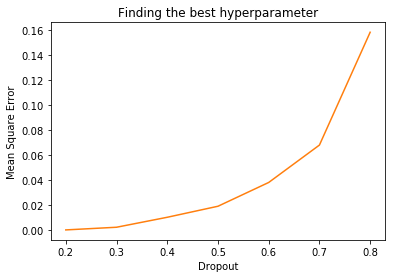

In [34]:
lists = sorted(dropout_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

12.2 Optimial epochs value

In [36]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochslist = [100, 200, 300, 400, 500, 600, 700, 800]

In [37]:
epochs_result = {}

for epochs in epochslist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
    epochs_result[epochs] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_31 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________
Trai

13702/13702 [==============================] - 1s - loss: 2.3914e-04 - acc: 0.0000e+00 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 51/100
13702/13702 [==============================] - 1s - loss: 2.4127e-04 - acc: 0.0000e+00 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 52/100
13702/13702 [==============================] - 1s - loss: 2.4155e-04 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 53/100
13702/13702 [==============================] - 1s - loss: 2.2529e-04 - acc: 0.0000e+00 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 54/100
13702/13702 [==============================] - 1s - loss: 2.3030e-04 - acc: 0.0000e+00 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 55/100
13702/13702 [==============================] - 1s - loss: 2.1516e-04 - acc: 0.0000e+00 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 56/100
13702/13702 [==============================] - 1s - loss: 2.2390e-04 - acc: 0.0000e+00 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 57/100
13702/13702 [

Train on 13702 samples, validate on 1523 samples
Epoch 1/200
13702/13702 [==============================] - 4s - loss: 0.0126 - acc: 0.0000e+00 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 2/200
13702/13702 [==============================] - 1s - loss: 0.0017 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 3/200
13702/13702 [==============================] - 1s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 7.0231e-04 - val_acc: 0.0000e+00
Epoch 4/200
13702/13702 [==============================] - 1s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 6.6957e-04 - val_acc: 0.0000e+00
Epoch 5/200
13702/13702 [==============================] - 1s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 3.9111e-04 - val_acc: 0.0000e+00
Epoch 6/200
13702/13702 [==============================] - 1s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 3.6979e-04 - val_acc: 0.0000e+00
Epoch 7/200
13702/13702 [==============================] - 1s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 5.0727e-04 -

13702/13702 [==============================] - 1s - loss: 2.4646e-04 - acc: 0.0000e+00 - val_loss: 0.0152 - val_acc: 0.0000e+00
Epoch 59/200
13702/13702 [==============================] - 1s - loss: 2.1853e-04 - acc: 0.0000e+00 - val_loss: 0.0128 - val_acc: 0.0000e+00
Epoch 60/200
13702/13702 [==============================] - 1s - loss: 2.2055e-04 - acc: 0.0000e+00 - val_loss: 0.0120 - val_acc: 0.0000e+00
Epoch 61/200
13702/13702 [==============================] - 1s - loss: 2.1577e-04 - acc: 0.0000e+00 - val_loss: 0.0140 - val_acc: 0.0000e+000.0000
Epoch 62/200
13702/13702 [==============================] - 1s - loss: 2.4173e-04 - acc: 0.0000e+00 - val_loss: 0.0126 - val_acc: 0.0000e+00
Epoch 63/200
13702/13702 [==============================] - 1s - loss: 2.0688e-04 - acc: 0.0000e+00 - val_loss: 0.0136 - val_acc: 0.0000e+00
Epoch 64/200
13702/13702 [==============================] - 1s - loss: 2.0772e-04 - acc: 0.0000e+00 - val_loss: 0.0163 - val_acc: 0.0000e+00
Epoch 65/200
13702/1

13702/13702 [==============================] - 1s - loss: 1.4490e-04 - acc: 0.0000e+00 - val_loss: 0.0251 - val_acc: 0.0000e+00
Epoch 117/200
13702/13702 [==============================] - 1s - loss: 1.4078e-04 - acc: 0.0000e+00 - val_loss: 0.0267 - val_acc: 0.0000e+000.00
Epoch 118/200
13702/13702 [==============================] - 1s - loss: 1.3944e-04 - acc: 0.0000e+00 - val_loss: 0.0253 - val_acc: 0.0000e+00
Epoch 119/200
13702/13702 [==============================] - 1s - loss: 1.5607e-04 - acc: 0.0000e+00 - val_loss: 0.0244 - val_acc: 0.0000e+00
Epoch 120/200
13702/13702 [==============================] - 1s - loss: 1.4014e-04 - acc: 0.0000e+00 - val_loss: 0.0258 - val_acc: 0.0000e+00
Epoch 121/200
13702/13702 [==============================] - 1s - loss: 1.4455e-04 - acc: 0.0000e+00 - val_loss: 0.0234 - val_acc: 0.0000e+00
Epoch 122/200
13702/13702 [==============================] - 1s - loss: 1.3886e-04 - acc: 0.0000e+00 - val_loss: 0.0229 - val_acc: 0.0000e+000.0000e+0 - ETA: 

13702/13702 [==============================] - 1s - loss: 1.2429e-04 - acc: 0.0000e+00 - val_loss: 0.0329 - val_acc: 0.0000e+00
Epoch 174/200
13702/13702 [==============================] - 1s - loss: 1.3190e-04 - acc: 0.0000e+00 - val_loss: 0.0336 - val_acc: 0.0000e+000.0000e+
Epoch 175/200
13702/13702 [==============================] - 1s - loss: 1.2603e-04 - acc: 0.0000e+00 - val_loss: 0.0327 - val_acc: 0.0000e+00
Epoch 176/200
13702/13702 [==============================] - 1s - loss: 1.3216e-04 - acc: 0.0000e+00 - val_loss: 0.0348 - val_acc: 0.0000e+00
Epoch 177/200
13702/13702 [==============================] - 1s - loss: 1.2542e-04 - acc: 0.0000e+00 - val_loss: 0.0353 - val_acc: 0.0000e+00
Epoch 178/200
13702/13702 [==============================] - 1s - loss: 1.2749e-04 - acc: 0.0000e+00 - val_loss: 0.0304 - val_acc: 0.0000e+00
Epoch 179/200
13702/13702 [==============================] - 1s - loss: 1.2242e-04 - acc: 0.0000e+00 - val_loss: 0.0334 - val_acc: 0.0000e+00
Epoch 180/20

13702/13702 [==============================] - 1s - loss: 6.0359e-04 - acc: 0.0000e+00 - val_loss: 0.0055 - val_acc: 0.0000e+00
Epoch 23/300
13702/13702 [==============================] - 1s - loss: 6.2189e-04 - acc: 0.0000e+00 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 24/300
13702/13702 [==============================] - 1s - loss: 6.2507e-04 - acc: 0.0000e+00 - val_loss: 0.0110 - val_acc: 0.0000e+00
Epoch 25/300
13702/13702 [==============================] - 1s - loss: 6.3672e-04 - acc: 0.0000e+00 - val_loss: 0.0103 - val_acc: 0.0000e+00
Epoch 26/300
13702/13702 [==============================] - 1s - loss: 5.6693e-04 - acc: 0.0000e+00 - val_loss: 0.0072 - val_acc: 0.0000e+00
Epoch 27/300
13702/13702 [==============================] - 1s - loss: 5.1941e-04 - acc: 0.0000e+00 - val_loss: 0.0072 - val_acc: 0.0000e+00
Epoch 28/300
13702/13702 [==============================] - 1s - loss: 5.1968e-04 - acc: 0.0000e+00 - val_loss: 0.0109 - val_acc: 0.0000e+00
Epoch 29/300
13702/13702 [

13702/13702 [==============================] - 1s - loss: 1.7899e-04 - acc: 0.0000e+00 - val_loss: 0.0213 - val_acc: 0.0000e+00
Epoch 80/300
13702/13702 [==============================] - 1s - loss: 1.8202e-04 - acc: 0.0000e+00 - val_loss: 0.0197 - val_acc: 0.0000e+00
Epoch 81/300
13702/13702 [==============================] - 1s - loss: 1.8453e-04 - acc: 0.0000e+00 - val_loss: 0.0222 - val_acc: 0.0000e+00
Epoch 82/300
13702/13702 [==============================] - 1s - loss: 1.8710e-04 - acc: 0.0000e+00 - val_loss: 0.0228 - val_acc: 0.0000e+00
Epoch 83/300
13702/13702 [==============================] - 1s - loss: 2.1143e-04 - acc: 0.0000e+00 - val_loss: 0.0233 - val_acc: 0.0000e+00
Epoch 84/300
13702/13702 [==============================] - 1s - loss: 1.9417e-04 - acc: 0.0000e+00 - val_loss: 0.0230 - val_acc: 0.0000e+00
Epoch 85/300
13702/13702 [==============================] - 1s - loss: 1.8811e-04 - acc: 0.0000e+00 - val_loss: 0.0214 - val_acc: 0.0000e+00
Epoch 86/300
13702/13702 [

13702/13702 [==============================] - 1s - loss: 1.5072e-04 - acc: 0.0000e+00 - val_loss: 0.0364 - val_acc: 0.0000e+00
Epoch 137/300
13702/13702 [==============================] - 1s - loss: 1.5001e-04 - acc: 0.0000e+00 - val_loss: 0.0363 - val_acc: 0.0000e+00
Epoch 138/300
13702/13702 [==============================] - 1s - loss: 1.4717e-04 - acc: 0.0000e+00 - val_loss: 0.0325 - val_acc: 0.0000e+00
Epoch 139/300
13702/13702 [==============================] - 1s - loss: 1.5026e-04 - acc: 0.0000e+00 - val_loss: 0.0329 - val_acc: 0.0000e+00
Epoch 140/300
13702/13702 [==============================] - 1s - loss: 1.6035e-04 - acc: 0.0000e+00 - val_loss: 0.0318 - val_acc: 0.0000e+00
Epoch 141/300
13702/13702 [==============================] - 1s - loss: 1.4425e-04 - acc: 0.0000e+00 - val_loss: 0.0341 - val_acc: 0.0000e+00
Epoch 142/300
13702/13702 [==============================] - 1s - loss: 1.4424e-04 - acc: 0.0000e+00 - val_loss: 0.0350 - val_acc: 0.0000e+00
Epoch 143/300
13702/

13702/13702 [==============================] - 1s - loss: 1.2958e-04 - acc: 0.0000e+00 - val_loss: 0.0413 - val_acc: 0.0000e+00
Epoch 194/300
13702/13702 [==============================] - 1s - loss: 1.2525e-04 - acc: 0.0000e+00 - val_loss: 0.0425 - val_acc: 0.0000e+00
Epoch 195/300
13702/13702 [==============================] - 1s - loss: 1.2583e-04 - acc: 0.0000e+00 - val_loss: 0.0416 - val_acc: 0.0000e+00
Epoch 196/300
13702/13702 [==============================] - 1s - loss: 1.1962e-04 - acc: 0.0000e+00 - val_loss: 0.0423 - val_acc: 0.0000e+00
Epoch 197/300
13702/13702 [==============================] - 1s - loss: 1.3163e-04 - acc: 0.0000e+00 - val_loss: 0.0407 - val_acc: 0.0000e+00
Epoch 198/300
13702/13702 [==============================] - 1s - loss: 1.2336e-04 - acc: 0.0000e+00 - val_loss: 0.0415 - val_acc: 0.0000e+00
Epoch 199/300
13702/13702 [==============================] - 1s - loss: 1.3977e-04 - acc: 0.0000e+00 - val_loss: 0.0429 - val_acc: 0.0000e+00
Epoch 200/300
13702/

13702/13702 [==============================] - 1s - loss: 1.1920e-04 - acc: 0.0000e+00 - val_loss: 0.0474 - val_acc: 0.0000e+00
Epoch 251/300
13702/13702 [==============================] - 1s - loss: 1.2527e-04 - acc: 0.0000e+00 - val_loss: 0.0490 - val_acc: 0.0000e+00
Epoch 252/300
13702/13702 [==============================] - 1s - loss: 1.2360e-04 - acc: 0.0000e+00 - val_loss: 0.0477 - val_acc: 0.0000e+00
Epoch 253/300
13702/13702 [==============================] - 1s - loss: 1.2407e-04 - acc: 0.0000e+00 - val_loss: 0.0476 - val_acc: 0.0000e+00
Epoch 254/300
13702/13702 [==============================] - 1s - loss: 1.2156e-04 - acc: 0.0000e+00 - val_loss: 0.0498 - val_acc: 0.0000e+00
Epoch 255/300
13702/13702 [==============================] - 1s - loss: 1.2368e-04 - acc: 0.0000e+00 - val_loss: 0.0495 - val_acc: 0.0000e+00
Epoch 256/300
13702/13702 [==============================] - 1s - loss: 1.3398e-04 - acc: 0.0000e+00 - val_loss: 0.0479 - val_acc: 0.0000e+00
Epoch 257/300
13702/

13702/13702 [==============================] - 4s - loss: 0.0149 - acc: 0.0000e+00 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 2/400
13702/13702 [==============================] - 1s - loss: 0.0019 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 3/400
13702/13702 [==============================] - 1s - loss: 0.0014 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 4/400
13702/13702 [==============================] - 1s - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 5.2632e-04 - val_acc: 0.0000e+00
Epoch 5/400
13702/13702 [==============================] - 1s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 5.9650e-04 - val_acc: 0.0000e+00
Epoch 6/400
13702/13702 [==============================] - 1s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 7/400
13702/13702 [==============================] - 1s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 3.8581e-04 - val_acc: 0.0000e+00
Epoch 8/400
13702/13702 [=======================

13702/13702 [==============================] - 1s - loss: 2.2346e-04 - acc: 0.0000e+00 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 60/400
13702/13702 [==============================] - 1s - loss: 2.2161e-04 - acc: 0.0000e+00 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 61/400
13702/13702 [==============================] - 1s - loss: 2.1132e-04 - acc: 0.0000e+00 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 62/400
13702/13702 [==============================] - 1s - loss: 2.1288e-04 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 63/400
13702/13702 [==============================] - 1s - loss: 2.0361e-04 - acc: 0.0000e+00 - val_loss: 0.0052 - val_acc: 0.0000e+00
Epoch 64/400
13702/13702 [==============================] - 1s - loss: 2.1014e-04 - acc: 0.0000e+00 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 65/400
13702/13702 [==============================] - 1s - loss: 2.0627e-04 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0000e+000.0000e+0
Epoch 66/400
1370

13702/13702 [==============================] - 1s - loss: 1.6140e-04 - acc: 0.0000e+00 - val_loss: 0.0068 - val_acc: 0.0000e+000
Epoch 118/400
13702/13702 [==============================] - 1s - loss: 1.6150e-04 - acc: 0.0000e+00 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 119/400
13702/13702 [==============================] - 1s - loss: 1.6106e-04 - acc: 0.0000e+00 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 120/400
13702/13702 [==============================] - 1s - loss: 1.6184e-04 - acc: 0.0000e+00 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 121/400
13702/13702 [==============================] - 1s - loss: 1.6901e-04 - acc: 0.0000e+00 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 122/400
13702/13702 [==============================] - 1s - loss: 1.6049e-04 - acc: 0.0000e+00 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 123/400
13702/13702 [==============================] - 1s - loss: 1.6952e-04 - acc: 0.0000e+00 - val_loss: 0.0051 - val_acc: 0.0000e+00
Epoch 124/400
13702

13702/13702 [==============================] - 1s - loss: 1.3666e-04 - acc: 0.0000e+00 - val_loss: 0.0127 - val_acc: 0.0000e+00
Epoch 175/400
13702/13702 [==============================] - 1s - loss: 1.3487e-04 - acc: 0.0000e+00 - val_loss: 0.0121 - val_acc: 0.0000e+00
Epoch 176/400
13702/13702 [==============================] - 1s - loss: 1.4246e-04 - acc: 0.0000e+00 - val_loss: 0.0123 - val_acc: 0.0000e+00
Epoch 177/400
13702/13702 [==============================] - 1s - loss: 1.3692e-04 - acc: 0.0000e+00 - val_loss: 0.0136 - val_acc: 0.0000e+00
Epoch 178/400
13702/13702 [==============================] - 1s - loss: 1.3950e-04 - acc: 0.0000e+00 - val_loss: 0.0132 - val_acc: 0.0000e+00
Epoch 179/400
13702/13702 [==============================] - 1s - loss: 1.2886e-04 - acc: 0.0000e+00 - val_loss: 0.0115 - val_acc: 0.0000e+00
Epoch 180/400
13702/13702 [==============================] - 1s - loss: 1.3165e-04 - acc: 0.0000e+00 - val_loss: 0.0135 - val_acc: 0.0000e+000
Epoch 181/400
13702

13702/13702 [==============================] - 1s - loss: 1.2163e-04 - acc: 0.0000e+00 - val_loss: 0.0209 - val_acc: 0.0000e+00
Epoch 232/400
13702/13702 [==============================] - 1s - loss: 1.1710e-04 - acc: 0.0000e+00 - val_loss: 0.0218 - val_acc: 0.0000e+000.
Epoch 233/400
13702/13702 [==============================] - 1s - loss: 1.1985e-04 - acc: 0.0000e+00 - val_loss: 0.0222 - val_acc: 0.0000e+00
Epoch 234/400
13702/13702 [==============================] - 1s - loss: 1.1844e-04 - acc: 0.0000e+00 - val_loss: 0.0220 - val_acc: 0.0000e+00
Epoch 235/400
13702/13702 [==============================] - 1s - loss: 1.1573e-04 - acc: 0.0000e+00 - val_loss: 0.0234 - val_acc: 0.0000e+00
Epoch 236/400
13702/13702 [==============================] - 1s - loss: 1.2026e-04 - acc: 0.0000e+00 - val_loss: 0.0207 - val_acc: 0.0000e+00
Epoch 237/400
13702/13702 [==============================] - 1s - loss: 1.2203e-04 - acc: 0.0000e+00 - val_loss: 0.0237 - val_acc: 0.0000e+00
Epoch 238/400
1370

13702/13702 [==============================] - 1s - loss: 1.0909e-04 - acc: 0.0000e+00 - val_loss: 0.0270 - val_acc: 0.0000e+00
Epoch 289/400
13702/13702 [==============================] - 1s - loss: 1.1154e-04 - acc: 0.0000e+00 - val_loss: 0.0264 - val_acc: 0.0000e+00
Epoch 290/400
13702/13702 [==============================] - 1s - loss: 1.1402e-04 - acc: 0.0000e+00 - val_loss: 0.0279 - val_acc: 0.0000e+00
Epoch 291/400
13702/13702 [==============================] - 1s - loss: 1.1161e-04 - acc: 0.0000e+00 - val_loss: 0.0265 - val_acc: 0.0000e+00
Epoch 292/400
13702/13702 [==============================] - 1s - loss: 1.1550e-04 - acc: 0.0000e+00 - val_loss: 0.0304 - val_acc: 0.0000e+00
Epoch 293/400
13702/13702 [==============================] - 1s - loss: 1.0776e-04 - acc: 0.0000e+00 - val_loss: 0.0284 - val_acc: 0.0000e+00
Epoch 294/400
13702/13702 [==============================] - 1s - loss: 1.0658e-04 - acc: 0.0000e+00 - val_loss: 0.0284 - val_acc: 0.0000e+00
Epoch 295/400
13702/

13702/13702 [==============================] - 1s - loss: 9.9296e-05 - acc: 0.0000e+00 - val_loss: 0.0315 - val_acc: 0.0000e+00
Epoch 346/400
13702/13702 [==============================] - 1s - loss: 1.0103e-04 - acc: 0.0000e+00 - val_loss: 0.0321 - val_acc: 0.0000e+00
Epoch 347/400
13702/13702 [==============================] - 1s - loss: 1.0592e-04 - acc: 0.0000e+00 - val_loss: 0.0312 - val_acc: 0.0000e+00
Epoch 348/400
13702/13702 [==============================] - 1s - loss: 1.0158e-04 - acc: 0.0000e+00 - val_loss: 0.0296 - val_acc: 0.0000e+00
Epoch 349/400
13702/13702 [==============================] - 1s - loss: 9.9124e-05 - acc: 0.0000e+00 - val_loss: 0.0326 - val_acc: 0.0000e+00
Epoch 350/400
13702/13702 [==============================] - 1s - loss: 1.0397e-04 - acc: 0.0000e+00 - val_loss: 0.0314 - val_acc: 0.0000e+00
Epoch 351/400
13702/13702 [==============================] - 1s - loss: 1.0080e-04 - acc: 0.0000e+00 - val_loss: 0.0311 - val_acc: 0.0000e+00
Epoch 352/400
13702/

Train on 13702 samples, validate on 1523 samples
Epoch 1/500
13702/13702 [==============================] - 4s - loss: 0.0139 - acc: 0.0000e+00 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 2/500
13702/13702 [==============================] - 1s - loss: 0.0020 - acc: 0.0000e+00 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 3/500
13702/13702 [==============================] - 1s - loss: 0.0014 - acc: 0.0000e+00 - val_loss: 7.3664e-04 - val_acc: 0.0000e+00
Epoch 4/500
13702/13702 [==============================] - 1s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 8.0779e-04 - val_acc: 0.0000e+00
Epoch 5/500
13702/13702 [==============================] - 1s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 6/500
13702/13702 [==============================] - 1s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 7/500
13702/13702 [==============================] - 1s - loss: 9.9785e-04 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc

13702/13702 [==============================] - 1s - loss: 2.1167e-04 - acc: 0.0000e+00 - val_loss: 0.0115 - val_acc: 0.0000e+00
Epoch 59/500
13702/13702 [==============================] - 1s - loss: 2.1400e-04 - acc: 0.0000e+00 - val_loss: 0.0105 - val_acc: 0.0000e+00
Epoch 60/500
13702/13702 [==============================] - 1s - loss: 2.0602e-04 - acc: 0.0000e+00 - val_loss: 0.0141 - val_acc: 0.0000e+00
Epoch 61/500
13702/13702 [==============================] - 1s - loss: 2.3937e-04 - acc: 0.0000e+00 - val_loss: 0.0151 - val_acc: 0.0000e+00
Epoch 62/500
13702/13702 [==============================] - 1s - loss: 2.1772e-04 - acc: 0.0000e+00 - val_loss: 0.0144 - val_acc: 0.0000e+00
Epoch 63/500
13702/13702 [==============================] - 1s - loss: 2.0643e-04 - acc: 0.0000e+00 - val_loss: 0.0106 - val_acc: 0.0000e+00
Epoch 64/500
13702/13702 [==============================] - 1s - loss: 2.0962e-04 - acc: 0.0000e+00 - val_loss: 0.0130 - val_acc: 0.0000e+00
Epoch 65/500
13702/13702 [

13702/13702 [==============================] - 1s - loss: 1.6540e-04 - acc: 0.0000e+00 - val_loss: 0.0194 - val_acc: 0.0000e+00
Epoch 116/500
13702/13702 [==============================] - 1s - loss: 1.7434e-04 - acc: 0.0000e+00 - val_loss: 0.0201 - val_acc: 0.0000e+00
Epoch 117/500
13702/13702 [==============================] - 1s - loss: 1.6266e-04 - acc: 0.0000e+00 - val_loss: 0.0199 - val_acc: 0.0000e+00
Epoch 118/500
13702/13702 [==============================] - 1s - loss: 1.7613e-04 - acc: 0.0000e+00 - val_loss: 0.0176 - val_acc: 0.0000e+00
Epoch 119/500
13702/13702 [==============================] - 1s - loss: 1.7546e-04 - acc: 0.0000e+00 - val_loss: 0.0168 - val_acc: 0.0000e+00
Epoch 120/500
13702/13702 [==============================] - 1s - loss: 1.7791e-04 - acc: 0.0000e+00 - val_loss: 0.0154 - val_acc: 0.0000e+00
Epoch 121/500
13702/13702 [==============================] - 1s - loss: 1.8168e-04 - acc: 0.0000e+00 - val_loss: 0.0198 - val_acc: 0.0000e+000.000 - ETA: 0s - los

13702/13702 [==============================] - 1s - loss: 1.4959e-04 - acc: 0.0000e+00 - val_loss: 0.0304 - val_acc: 0.0000e+00
Epoch 173/500
13702/13702 [==============================] - 1s - loss: 1.4894e-04 - acc: 0.0000e+00 - val_loss: 0.0314 - val_acc: 0.0000e+00
Epoch 174/500
13702/13702 [==============================] - 1s - loss: 1.4225e-04 - acc: 0.0000e+00 - val_loss: 0.0327 - val_acc: 0.0000e+00
Epoch 175/500
13702/13702 [==============================] - 1s - loss: 1.3793e-04 - acc: 0.0000e+00 - val_loss: 0.0310 - val_acc: 0.0000e+00
Epoch 176/500
13702/13702 [==============================] - 1s - loss: 1.4310e-04 - acc: 0.0000e+00 - val_loss: 0.0308 - val_acc: 0.0000e+00
Epoch 177/500
13702/13702 [==============================] - 1s - loss: 1.5189e-04 - acc: 0.0000e+00 - val_loss: 0.0327 - val_acc: 0.0000e+00
Epoch 178/500
13702/13702 [==============================] - 1s - loss: 1.4554e-04 - acc: 0.0000e+00 - val_loss: 0.0333 - val_acc: 0.0000e+00
Epoch 179/500
13702/

13702/13702 [==============================] - 1s - loss: 1.3032e-04 - acc: 0.0000e+00 - val_loss: 0.0397 - val_acc: 0.0000e+00
Epoch 230/500
13702/13702 [==============================] - 1s - loss: 1.2581e-04 - acc: 0.0000e+00 - val_loss: 0.0410 - val_acc: 0.0000e+00
Epoch 231/500
13702/13702 [==============================] - 1s - loss: 1.3079e-04 - acc: 0.0000e+00 - val_loss: 0.0387 - val_acc: 0.0000e+00
Epoch 232/500
13702/13702 [==============================] - 1s - loss: 1.2741e-04 - acc: 0.0000e+00 - val_loss: 0.0404 - val_acc: 0.0000e+00
Epoch 233/500
13702/13702 [==============================] - 1s - loss: 1.2250e-04 - acc: 0.0000e+00 - val_loss: 0.0393 - val_acc: 0.0000e+00
Epoch 234/500
13702/13702 [==============================] - 1s - loss: 1.2401e-04 - acc: 0.0000e+00 - val_loss: 0.0359 - val_acc: 0.0000e+00
Epoch 235/500
13702/13702 [==============================] - 1s - loss: 1.2734e-04 - acc: 0.0000e+00 - val_loss: 0.0367 - val_acc: 0.0000e+00
Epoch 236/500
13702/

13702/13702 [==============================] - 1s - loss: 1.0825e-04 - acc: 0.0000e+00 - val_loss: 0.0490 - val_acc: 0.0000e+00
Epoch 287/500
13702/13702 [==============================] - 1s - loss: 1.1171e-04 - acc: 0.0000e+00 - val_loss: 0.0515 - val_acc: 0.0000e+00
Epoch 288/500
13702/13702 [==============================] - 1s - loss: 1.1665e-04 - acc: 0.0000e+00 - val_loss: 0.0489 - val_acc: 0.0000e+00
Epoch 289/500
13702/13702 [==============================] - 1s - loss: 1.0917e-04 - acc: 0.0000e+00 - val_loss: 0.0488 - val_acc: 0.0000e+00
Epoch 290/500
13702/13702 [==============================] - 1s - loss: 1.1865e-04 - acc: 0.0000e+00 - val_loss: 0.0469 - val_acc: 0.0000e+000.0
Epoch 291/500
13702/13702 [==============================] - 1s - loss: 1.0890e-04 - acc: 0.0000e+00 - val_loss: 0.0477 - val_acc: 0.0000e+00
Epoch 292/500
13702/13702 [==============================] - 1s - loss: 1.1160e-04 - acc: 0.0000e+00 - val_loss: 0.0488 - val_acc: 0.0000e+00
Epoch 293/500
137

13702/13702 [==============================] - 1s - loss: 1.0314e-04 - acc: 0.0000e+00 - val_loss: 0.0511 - val_acc: 0.0000e+00
Epoch 344/500
13702/13702 [==============================] - 1s - loss: 1.0571e-04 - acc: 0.0000e+00 - val_loss: 0.0511 - val_acc: 0.0000e+00
Epoch 345/500
13702/13702 [==============================] - 1s - loss: 1.0446e-04 - acc: 0.0000e+00 - val_loss: 0.0513 - val_acc: 0.0000e+00
Epoch 346/500
13702/13702 [==============================] - 1s - loss: 9.5354e-05 - acc: 0.0000e+00 - val_loss: 0.0501 - val_acc: 0.0000e+00
Epoch 347/500
13702/13702 [==============================] - 1s - loss: 1.0494e-04 - acc: 0.0000e+00 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 348/500
13702/13702 [==============================] - 1s - loss: 1.0678e-04 - acc: 0.0000e+00 - val_loss: 0.0496 - val_acc: 0.0000e+00
Epoch 349/500
13702/13702 [==============================] - 1s - loss: 1.1250e-04 - acc: 0.0000e+00 - val_loss: 0.0510 - val_acc: 0.0000e+00
Epoch 350/500
13702/

13702/13702 [==============================] - 1s - loss: 1.0054e-04 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 401/500
13702/13702 [==============================] - 1s - loss: 8.9809e-05 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 402/500
13702/13702 [==============================] - 1s - loss: 9.4681e-05 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 403/500
13702/13702 [==============================] - 1s - loss: 9.3252e-05 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 404/500
13702/13702 [==============================] - 1s - loss: 9.0505e-05 - acc: 0.0000e+00 - val_loss: 0.0552 - val_acc: 0.0000e+00
Epoch 405/500
13702/13702 [==============================] - 1s - loss: 9.3794e-05 - acc: 0.0000e+00 - val_loss: 0.0561 - val_acc: 0.0000e+00
Epoch 406/500
13702/13702 [==============================] - 1s - loss: 9.0145e-05 - acc: 0.0000e+00 - val_loss: 0.0531 - val_acc: 0.0000e+00
Epoch 407/500
13702/

13702/13702 [==============================] - 1s - loss: 8.6210e-05 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 458/500
13702/13702 [==============================] - 1s - loss: 8.7092e-05 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 459/500
13702/13702 [==============================] - 1s - loss: 9.1246e-05 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 460/500
13702/13702 [==============================] - 1s - loss: 9.0340e-05 - acc: 0.0000e+00 - val_loss: 0.0543 - val_acc: 0.0000e+00
Epoch 461/500
13702/13702 [==============================] - 1s - loss: 8.4615e-05 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 462/500
13702/13702 [==============================] - 1s - loss: 8.8857e-05 - acc: 0.0000e+00 - val_loss: 0.0544 - val_acc: 0.0000e+00
Epoch 463/500
13702/13702 [==============================] - 1s - loss: 9.1121e-05 - acc: 0.0000e+00 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 464/500
13702/

13702/13702 [==============================] - 1s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 7/600
13702/13702 [==============================] - 1s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 8/600
13702/13702 [==============================] - 1s - loss: 9.8329e-04 - acc: 0.0000e+00 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 9/600
13702/13702 [==============================] - 1s - loss: 9.7195e-04 - acc: 0.0000e+00 - val_loss: 5.6432e-04 - val_acc: 0.0000e+00
Epoch 10/600
13702/13702 [==============================] - 1s - loss: 9.3763e-04 - acc: 0.0000e+00 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 11/600
13702/13702 [==============================] - 1s - loss: 8.8637e-04 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 12/600
13702/13702 [==============================] - 1s - loss: 8.7631e-04 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+000.00 - ETA: 0s - loss: 8.7738e-04 

13702/13702 [==============================] - 1s - loss: 2.0409e-04 - acc: 0.0000e+00 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 64/600
13702/13702 [==============================] - 1s - loss: 2.0169e-04 - acc: 0.0000e+00 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 65/600
13702/13702 [==============================] - 1s - loss: 1.9904e-04 - acc: 0.0000e+00 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 66/600
13702/13702 [==============================] - 1s - loss: 2.0690e-04 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 67/600
13702/13702 [==============================] - 1s - loss: 2.0635e-04 - acc: 0.0000e+00 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 68/600
13702/13702 [==============================] - 1s - loss: 2.0860e-04 - acc: 0.0000e+00 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 69/600
13702/13702 [==============================] - 1s - loss: 2.0635e-04 - acc: 0.0000e+00 - val_loss: 0.0055 - val_acc: 0.0000e+00
Epoch 70/600
13702/13702 [

13702/13702 [==============================] - 1s - loss: 1.5883e-04 - acc: 0.0000e+00 - val_loss: 0.0072 - val_acc: 0.0000e+00
Epoch 122/600
13702/13702 [==============================] - 1s - loss: 1.6358e-04 - acc: 0.0000e+00 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 123/600
13702/13702 [==============================] - 1s - loss: 1.5923e-04 - acc: 0.0000e+00 - val_loss: 0.0068 - val_acc: 0.0000e+00
Epoch 124/600
13702/13702 [==============================] - 1s - loss: 1.5376e-04 - acc: 0.0000e+00 - val_loss: 0.0052 - val_acc: 0.0000e+00
Epoch 125/600
13702/13702 [==============================] - 1s - loss: 1.6314e-04 - acc: 0.0000e+00 - val_loss: 0.0070 - val_acc: 0.0000e+00
Epoch 126/600
13702/13702 [==============================] - 1s - loss: 1.5900e-04 - acc: 0.0000e+00 - val_loss: 0.0072 - val_acc: 0.0000e+00
Epoch 127/600
13702/13702 [==============================] - 1s - loss: 1.5739e-04 - acc: 0.0000e+00 - val_loss: 0.0079 - val_acc: 0.0000e+00
Epoch 128/600
13702/

13702/13702 [==============================] - 1s - loss: 1.4096e-04 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 179/600
13702/13702 [==============================] - 1s - loss: 1.3660e-04 - acc: 0.0000e+00 - val_loss: 0.0118 - val_acc: 0.0000e+00
Epoch 180/600
13702/13702 [==============================] - 1s - loss: 1.5444e-04 - acc: 0.0000e+00 - val_loss: 0.0111 - val_acc: 0.0000e+00
Epoch 181/600
13702/13702 [==============================] - 1s - loss: 1.5384e-04 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 182/600
13702/13702 [==============================] - 1s - loss: 1.3464e-04 - acc: 0.0000e+00 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 183/600
13702/13702 [==============================] - 1s - loss: 1.3578e-04 - acc: 0.0000e+00 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 184/600
13702/13702 [==============================] - 1s - loss: 1.4650e-04 - acc: 0.0000e+00 - val_loss: 0.0105 - val_acc: 0.0000e+00
Epoch 185/600
13702/

13702/13702 [==============================] - 1s - loss: 1.1694e-04 - acc: 0.0000e+00 - val_loss: 0.0164 - val_acc: 0.0000e+00
Epoch 236/600
13702/13702 [==============================] - 1s - loss: 1.2400e-04 - acc: 0.0000e+00 - val_loss: 0.0143 - val_acc: 0.0000e+00
Epoch 237/600
13702/13702 [==============================] - 1s - loss: 1.2360e-04 - acc: 0.0000e+00 - val_loss: 0.0156 - val_acc: 0.0000e+00
Epoch 238/600
13702/13702 [==============================] - 1s - loss: 1.3130e-04 - acc: 0.0000e+00 - val_loss: 0.0142 - val_acc: 0.0000e+00
Epoch 239/600
13702/13702 [==============================] - 1s - loss: 1.2378e-04 - acc: 0.0000e+00 - val_loss: 0.0154 - val_acc: 0.0000e+00
Epoch 240/600
13702/13702 [==============================] - 1s - loss: 1.1681e-04 - acc: 0.0000e+00 - val_loss: 0.0166 - val_acc: 0.0000e+00
Epoch 241/600
13702/13702 [==============================] - 1s - loss: 1.2077e-04 - acc: 0.0000e+00 - val_loss: 0.0162 - val_acc: 0.0000e+00
Epoch 242/600
13702/

13702/13702 [==============================] - 1s - loss: 1.0480e-04 - acc: 0.0000e+00 - val_loss: 0.0220 - val_acc: 0.0000e+00
Epoch 293/600
13702/13702 [==============================] - 1s - loss: 1.1134e-04 - acc: 0.0000e+00 - val_loss: 0.0218 - val_acc: 0.0000e+00
Epoch 294/600
13702/13702 [==============================] - 1s - loss: 1.2164e-04 - acc: 0.0000e+00 - val_loss: 0.0228 - val_acc: 0.0000e+00
Epoch 295/600
13702/13702 [==============================] - 1s - loss: 1.0068e-04 - acc: 0.0000e+00 - val_loss: 0.0213 - val_acc: 0.0000e+00
Epoch 296/600
13702/13702 [==============================] - 1s - loss: 1.1305e-04 - acc: 0.0000e+00 - val_loss: 0.0209 - val_acc: 0.0000e+00
Epoch 297/600
13702/13702 [==============================] - 1s - loss: 1.1832e-04 - acc: 0.0000e+00 - val_loss: 0.0224 - val_acc: 0.0000e+00
Epoch 298/600
13702/13702 [==============================] - 1s - loss: 1.1081e-04 - acc: 0.0000e+00 - val_loss: 0.0221 - val_acc: 0.0000e+00TA: 0s - loss: 1.1041

13702/13702 [==============================] - 1s - loss: 1.0552e-04 - acc: 0.0000e+00 - val_loss: 0.0257 - val_acc: 0.0000e+00
Epoch 350/600
13702/13702 [==============================] - 1s - loss: 9.5693e-05 - acc: 0.0000e+00 - val_loss: 0.0255 - val_acc: 0.0000e+00
Epoch 351/600
13702/13702 [==============================] - 1s - loss: 1.0683e-04 - acc: 0.0000e+00 - val_loss: 0.0276 - val_acc: 0.0000e+00
Epoch 352/600
13702/13702 [==============================] - 1s - loss: 1.0423e-04 - acc: 0.0000e+00 - val_loss: 0.0263 - val_acc: 0.0000e+000.0000e+
Epoch 353/600
13702/13702 [==============================] - 1s - loss: 9.8779e-05 - acc: 0.0000e+00 - val_loss: 0.0270 - val_acc: 0.0000e+00
Epoch 354/600
13702/13702 [==============================] - 1s - loss: 9.8216e-05 - acc: 0.0000e+00 - val_loss: 0.0243 - val_acc: 0.0000e+00
Epoch 355/600
13702/13702 [==============================] - 1s - loss: 9.7549e-05 - acc: 0.0000e+00 - val_loss: 0.0257 - val_acc: 0.0000e+00
Epoch 356/60

13702/13702 [==============================] - 1s - loss: 8.6230e-05 - acc: 0.0000e+00 - val_loss: 0.0272 - val_acc: 0.0000e+00
Epoch 407/600
13702/13702 [==============================] - 1s - loss: 9.0832e-05 - acc: 0.0000e+00 - val_loss: 0.0290 - val_acc: 0.0000e+00
Epoch 408/600
13702/13702 [==============================] - 1s - loss: 9.4519e-05 - acc: 0.0000e+00 - val_loss: 0.0276 - val_acc: 0.0000e+00
Epoch 409/600
13702/13702 [==============================] - 1s - loss: 9.1379e-05 - acc: 0.0000e+00 - val_loss: 0.0281 - val_acc: 0.0000e+00
Epoch 410/600
13702/13702 [==============================] - 1s - loss: 8.7524e-05 - acc: 0.0000e+00 - val_loss: 0.0299 - val_acc: 0.0000e+00
Epoch 411/600
13702/13702 [==============================] - 1s - loss: 8.7965e-05 - acc: 0.0000e+00 - val_loss: 0.0278 - val_acc: 0.0000e+00
Epoch 412/600
13702/13702 [==============================] - 1s - loss: 8.9192e-05 - acc: 0.0000e+00 - val_loss: 0.0292 - val_acc: 0.0000e+00
Epoch 413/600
13702/

13702/13702 [==============================] - 1s - loss: 8.9616e-05 - acc: 0.0000e+00 - val_loss: 0.0291 - val_acc: 0.0000e+00
Epoch 464/600
13702/13702 [==============================] - 1s - loss: 9.0194e-05 - acc: 0.0000e+00 - val_loss: 0.0276 - val_acc: 0.0000e+00
Epoch 465/600
13702/13702 [==============================] - 1s - loss: 8.5454e-05 - acc: 0.0000e+00 - val_loss: 0.0294 - val_acc: 0.0000e+00
Epoch 466/600
13702/13702 [==============================] - 1s - loss: 8.4160e-05 - acc: 0.0000e+00 - val_loss: 0.0286 - val_acc: 0.0000e+000.
Epoch 467/600
13702/13702 [==============================] - 1s - loss: 8.7912e-05 - acc: 0.0000e+00 - val_loss: 0.0284 - val_acc: 0.0000e+00
Epoch 468/600
13702/13702 [==============================] - 1s - loss: 8.9876e-05 - acc: 0.0000e+00 - val_loss: 0.0277 - val_acc: 0.0000e+00
Epoch 469/600
13702/13702 [==============================] - 1s - loss: 9.2081e-05 - acc: 0.0000e+00 - val_loss: 0.0287 - val_acc: 0.0000e+00
Epoch 470/600
1370

13702/13702 [==============================] - 1s - loss: 7.6479e-05 - acc: 0.0000e+00 - val_loss: 0.0293 - val_acc: 0.0000e+000.00
Epoch 521/600
13702/13702 [==============================] - 1s - loss: 7.8418e-05 - acc: 0.0000e+00 - val_loss: 0.0296 - val_acc: 0.0000e+00
Epoch 522/600
13702/13702 [==============================] - 1s - loss: 8.4598e-05 - acc: 0.0000e+00 - val_loss: 0.0299 - val_acc: 0.0000e+00
Epoch 523/600
13702/13702 [==============================] - 1s - loss: 8.7083e-05 - acc: 0.0000e+00 - val_loss: 0.0310 - val_acc: 0.0000e+00
Epoch 524/600
13702/13702 [==============================] - 1s - loss: 9.0508e-05 - acc: 0.0000e+00 - val_loss: 0.0295 - val_acc: 0.0000e+00
Epoch 525/600
13702/13702 [==============================] - 1s - loss: 8.4888e-05 - acc: 0.0000e+00 - val_loss: 0.0317 - val_acc: 0.0000e+00
Epoch 526/600
13702/13702 [==============================] - 1s - loss: 8.1520e-05 - acc: 0.0000e+00 - val_loss: 0.0302 - val_acc: 0.0000e+00
Epoch 527/600
13

13702/13702 [==============================] - 1s - loss: 8.2524e-05 - acc: 0.0000e+00 - val_loss: 0.0296 - val_acc: 0.0000e+00
Epoch 578/600
13702/13702 [==============================] - 1s - loss: 8.4065e-05 - acc: 0.0000e+00 - val_loss: 0.0293 - val_acc: 0.0000e+00
Epoch 579/600
13702/13702 [==============================] - 1s - loss: 8.1878e-05 - acc: 0.0000e+00 - val_loss: 0.0315 - val_acc: 0.0000e+00
Epoch 580/600
13702/13702 [==============================] - 1s - loss: 7.8656e-05 - acc: 0.0000e+00 - val_loss: 0.0319 - val_acc: 0.0000e+00
Epoch 581/600
13702/13702 [==============================] - 1s - loss: 7.7811e-05 - acc: 0.0000e+00 - val_loss: 0.0312 - val_acc: 0.0000e+00
Epoch 582/600
13702/13702 [==============================] - 1s - loss: 7.7766e-05 - acc: 0.0000e+00 - val_loss: 0.0321 - val_acc: 0.0000e+00
Epoch 583/600
13702/13702 [==============================] - 1s - loss: 7.7908e-05 - acc: 0.0000e+00 - val_loss: 0.0307 - val_acc: 0.0000e+00
Epoch 584/600
13702/

13702/13702 [==============================] - 1s - loss: 4.9375e-04 - acc: 0.0000e+00 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 27/700
13702/13702 [==============================] - 1s - loss: 4.8191e-04 - acc: 0.0000e+00 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 28/700
13702/13702 [==============================] - 1s - loss: 4.7500e-04 - acc: 0.0000e+00 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 29/700
13702/13702 [==============================] - 1s - loss: 4.3162e-04 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0000e+00
Epoch 30/700
13702/13702 [==============================] - 1s - loss: 4.8282e-04 - acc: 0.0000e+00 - val_loss: 0.0066 - val_acc: 0.0000e+000.000
Epoch 31/700
13702/13702 [==============================] - 1s - loss: 4.1006e-04 - acc: 0.0000e+00 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 32/700
13702/13702 [==============================] - 1s - loss: 3.9472e-04 - acc: 0.0000e+00 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 33/700
13702/13

13702/13702 [==============================] - 1s - loss: 1.7382e-04 - acc: 0.0000e+00 - val_loss: 0.0169 - val_acc: 0.0000e+00
Epoch 84/700
13702/13702 [==============================] - 1s - loss: 1.8002e-04 - acc: 0.0000e+00 - val_loss: 0.0155 - val_acc: 0.0000e+00
Epoch 85/700
13702/13702 [==============================] - 1s - loss: 1.6794e-04 - acc: 0.0000e+00 - val_loss: 0.0163 - val_acc: 0.0000e+00
Epoch 86/700
13702/13702 [==============================] - 1s - loss: 1.9518e-04 - acc: 0.0000e+00 - val_loss: 0.0174 - val_acc: 0.0000e+00
Epoch 87/700
13702/13702 [==============================] - 1s - loss: 1.8549e-04 - acc: 0.0000e+00 - val_loss: 0.0181 - val_acc: 0.0000e+00
Epoch 88/700
13702/13702 [==============================] - 1s - loss: 1.7373e-04 - acc: 0.0000e+00 - val_loss: 0.0168 - val_acc: 0.0000e+00
Epoch 89/700
13702/13702 [==============================] - 1s - loss: 1.7257e-04 - acc: 0.0000e+00 - val_loss: 0.0165 - val_acc: 0.0000e+00
Epoch 90/700
13702/13702 [

13702/13702 [==============================] - 1s - loss: 1.4333e-04 - acc: 0.0000e+00 - val_loss: 0.0257 - val_acc: 0.0000e+00
Epoch 141/700
13702/13702 [==============================] - 1s - loss: 1.5015e-04 - acc: 0.0000e+00 - val_loss: 0.0269 - val_acc: 0.0000e+00
Epoch 142/700
13702/13702 [==============================] - 1s - loss: 1.4179e-04 - acc: 0.0000e+00 - val_loss: 0.0249 - val_acc: 0.0000e+00
Epoch 143/700
13702/13702 [==============================] - 1s - loss: 1.5902e-04 - acc: 0.0000e+00 - val_loss: 0.0265 - val_acc: 0.0000e+00
Epoch 144/700
13702/13702 [==============================] - 1s - loss: 1.4232e-04 - acc: 0.0000e+00 - val_loss: 0.0299 - val_acc: 0.0000e+00
Epoch 145/700
13702/13702 [==============================] - 1s - loss: 1.7678e-04 - acc: 0.0000e+00 - val_loss: 0.0314 - val_acc: 0.0000e+00
Epoch 146/700
13702/13702 [==============================] - 1s - loss: 1.5700e-04 - acc: 0.0000e+00 - val_loss: 0.0292 - val_acc: 0.0000e+00
Epoch 147/700
13702/

13702/13702 [==============================] - 1s - loss: 1.2834e-04 - acc: 0.0000e+00 - val_loss: 0.0349 - val_acc: 0.0000e+00
Epoch 198/700
13702/13702 [==============================] - 1s - loss: 1.5389e-04 - acc: 0.0000e+00 - val_loss: 0.0376 - val_acc: 0.0000e+00
Epoch 199/700
13702/13702 [==============================] - 1s - loss: 1.3246e-04 - acc: 0.0000e+00 - val_loss: 0.0388 - val_acc: 0.0000e+00
Epoch 200/700
13702/13702 [==============================] - 1s - loss: 1.3069e-04 - acc: 0.0000e+00 - val_loss: 0.0382 - val_acc: 0.0000e+00
Epoch 201/700
13702/13702 [==============================] - 1s - loss: 1.2310e-04 - acc: 0.0000e+00 - val_loss: 0.0367 - val_acc: 0.0000e+00
Epoch 202/700
13702/13702 [==============================] - 1s - loss: 1.3046e-04 - acc: 0.0000e+00 - val_loss: 0.0384 - val_acc: 0.0000e+00
Epoch 203/700
13702/13702 [==============================] - 1s - loss: 1.3277e-04 - acc: 0.0000e+00 - val_loss: 0.0376 - val_acc: 0.0000e+00
Epoch 204/700
13702/

13702/13702 [==============================] - 1s - loss: 1.2212e-04 - acc: 0.0000e+00 - val_loss: 0.0446 - val_acc: 0.0000e+00
Epoch 255/700
13702/13702 [==============================] - 1s - loss: 1.1364e-04 - acc: 0.0000e+00 - val_loss: 0.0421 - val_acc: 0.0000e+00
Epoch 256/700
13702/13702 [==============================] - 1s - loss: 1.1156e-04 - acc: 0.0000e+00 - val_loss: 0.0452 - val_acc: 0.0000e+00
Epoch 257/700
13702/13702 [==============================] - 1s - loss: 1.2157e-04 - acc: 0.0000e+00 - val_loss: 0.0439 - val_acc: 0.0000e+00
Epoch 258/700
13702/13702 [==============================] - 1s - loss: 1.1271e-04 - acc: 0.0000e+00 - val_loss: 0.0426 - val_acc: 0.0000e+00
Epoch 259/700
13702/13702 [==============================] - 1s - loss: 1.2236e-04 - acc: 0.0000e+00 - val_loss: 0.0464 - val_acc: 0.0000e+00
Epoch 260/700
13702/13702 [==============================] - 1s - loss: 1.2314e-04 - acc: 0.0000e+00 - val_loss: 0.0442 - val_acc: 0.0000e+000.0000e
Epoch 261/700

13702/13702 [==============================] - 1s - loss: 1.0909e-04 - acc: 0.0000e+00 - val_loss: 0.0494 - val_acc: 0.0000e+00
Epoch 312/700
13702/13702 [==============================] - 1s - loss: 1.0704e-04 - acc: 0.0000e+00 - val_loss: 0.0514 - val_acc: 0.0000e+000.0
Epoch 313/700
13702/13702 [==============================] - 1s - loss: 1.1287e-04 - acc: 0.0000e+00 - val_loss: 0.0490 - val_acc: 0.0000e+00
Epoch 314/700
13702/13702 [==============================] - 1s - loss: 1.1318e-04 - acc: 0.0000e+00 - val_loss: 0.0480 - val_acc: 0.0000e+00
Epoch 315/700
13702/13702 [==============================] - 1s - loss: 1.0591e-04 - acc: 0.0000e+00 - val_loss: 0.0509 - val_acc: 0.0000e+00
Epoch 316/700
13702/13702 [==============================] - 1s - loss: 1.1424e-04 - acc: 0.0000e+00 - val_loss: 0.0476 - val_acc: 0.0000e+00
Epoch 317/700
13702/13702 [==============================] - 1s - loss: 1.1693e-04 - acc: 0.0000e+00 - val_loss: 0.0490 - val_acc: 0.0000e+00
Epoch 318/700
137

13702/13702 [==============================] - 1s - loss: 9.7354e-05 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 369/700
13702/13702 [==============================] - 1s - loss: 9.5467e-05 - acc: 0.0000e+00 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 370/700
13702/13702 [==============================] - 1s - loss: 1.0500e-04 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 371/700
13702/13702 [==============================] - 1s - loss: 9.9885e-05 - acc: 0.0000e+00 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 372/700
13702/13702 [==============================] - 1s - loss: 9.6269e-05 - acc: 0.0000e+00 - val_loss: 0.0552 - val_acc: 0.0000e+00
Epoch 373/700
13702/13702 [==============================] - 1s - loss: 9.9514e-05 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 374/700
13702/13702 [==============================] - 1s - loss: 9.6482e-05 - acc: 0.0000e+00 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 375/700
13702/

13702/13702 [==============================] - 1s - loss: 9.8921e-05 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 426/700
13702/13702 [==============================] - 1s - loss: 9.3449e-05 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 427/700
13702/13702 [==============================] - 1s - loss: 9.0993e-05 - acc: 0.0000e+00 - val_loss: 0.0569 - val_acc: 0.0000e+000.0000e
Epoch 428/700
13702/13702 [==============================] - 1s - loss: 9.3308e-05 - acc: 0.0000e+00 - val_loss: 0.0619 - val_acc: 0.0000e+00
Epoch 429/700
13702/13702 [==============================] - 1s - loss: 8.8338e-05 - acc: 0.0000e+00 - val_loss: 0.0607 - val_acc: 0.0000e+00
Epoch 430/700
13702/13702 [==============================] - 1s - loss: 9.5213e-05 - acc: 0.0000e+00 - val_loss: 0.0587 - val_acc: 0.0000e+00
Epoch 431/700
13702/13702 [==============================] - 1s - loss: 9.6163e-05 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 432/700

13702/13702 [==============================] - 1s - loss: 8.4587e-05 - acc: 0.0000e+00 - val_loss: 0.0597 - val_acc: 0.0000e+000.
Epoch 483/700
13702/13702 [==============================] - 1s - loss: 8.6200e-05 - acc: 0.0000e+00 - val_loss: 0.0585 - val_acc: 0.0000e+00
Epoch 484/700
13702/13702 [==============================] - 1s - loss: 8.9504e-05 - acc: 0.0000e+00 - val_loss: 0.0583 - val_acc: 0.0000e+00
Epoch 485/700
13702/13702 [==============================] - 1s - loss: 9.6467e-05 - acc: 0.0000e+00 - val_loss: 0.0606 - val_acc: 0.0000e+00
Epoch 486/700
13702/13702 [==============================] - 1s - loss: 8.4596e-05 - acc: 0.0000e+00 - val_loss: 0.0595 - val_acc: 0.0000e+00
Epoch 487/700
13702/13702 [==============================] - 1s - loss: 7.8076e-05 - acc: 0.0000e+00 - val_loss: 0.0606 - val_acc: 0.0000e+00
Epoch 488/700
13702/13702 [==============================] - 1s - loss: 8.3778e-05 - acc: 0.0000e+00 - val_loss: 0.0605 - val_acc: 0.0000e+000.0000
Epoch 489/70

13702/13702 [==============================] - 1s - loss: 8.8515e-05 - acc: 0.0000e+00 - val_loss: 0.0593 - val_acc: 0.0000e+000.000
Epoch 540/700
13702/13702 [==============================] - 1s - loss: 7.7791e-05 - acc: 0.0000e+00 - val_loss: 0.0604 - val_acc: 0.0000e+00
Epoch 541/700
13702/13702 [==============================] - 1s - loss: 8.2684e-05 - acc: 0.0000e+00 - val_loss: 0.0575 - val_acc: 0.0000e+00
Epoch 542/700
13702/13702 [==============================] - 1s - loss: 8.1989e-05 - acc: 0.0000e+00 - val_loss: 0.0595 - val_acc: 0.0000e+00
Epoch 543/700
13702/13702 [==============================] - 1s - loss: 8.1412e-05 - acc: 0.0000e+00 - val_loss: 0.0597 - val_acc: 0.0000e+00
Epoch 544/700
13702/13702 [==============================] - 1s - loss: 7.9578e-05 - acc: 0.0000e+00 - val_loss: 0.0588 - val_acc: 0.0000e+00
Epoch 545/700
13702/13702 [==============================] - 1s - loss: 8.2886e-05 - acc: 0.0000e+00 - val_loss: 0.0585 - val_acc: 0.0000e+00
Epoch 546/700
1

13702/13702 [==============================] - 1s - loss: 8.2125e-05 - acc: 0.0000e+00 - val_loss: 0.0583 - val_acc: 0.0000e+00
Epoch 597/700
13702/13702 [==============================] - 1s - loss: 7.4841e-05 - acc: 0.0000e+00 - val_loss: 0.0581 - val_acc: 0.0000e+000.0000e+0
Epoch 598/700
13702/13702 [==============================] - 1s - loss: 7.3889e-05 - acc: 0.0000e+00 - val_loss: 0.0576 - val_acc: 0.0000e+00
Epoch 599/700
13702/13702 [==============================] - 1s - loss: 7.6290e-05 - acc: 0.0000e+00 - val_loss: 0.0591 - val_acc: 0.0000e+00
Epoch 600/700
13702/13702 [==============================] - 1s - loss: 8.3854e-05 - acc: 0.0000e+00 - val_loss: 0.0591 - val_acc: 0.0000e+00
Epoch 601/700
13702/13702 [==============================] - 1s - loss: 7.9411e-05 - acc: 0.0000e+00 - val_loss: 0.0579 - val_acc: 0.0000e+00
Epoch 602/700
13702/13702 [==============================] - 1s - loss: 7.5271e-05 - acc: 0.0000e+00 - val_loss: 0.0588 - val_acc: 0.0000e+00
Epoch 603/7

13702/13702 [==============================] - 1s - loss: 7.0858e-05 - acc: 0.0000e+00 - val_loss: 0.0593 - val_acc: 0.0000e+00
Epoch 654/700
13702/13702 [==============================] - 1s - loss: 7.2972e-05 - acc: 0.0000e+00 - val_loss: 0.0606 - val_acc: 0.0000e+00
Epoch 655/700
13702/13702 [==============================] - 1s - loss: 7.3614e-05 - acc: 0.0000e+00 - val_loss: 0.0592 - val_acc: 0.0000e+00
Epoch 656/700
13702/13702 [==============================] - 1s - loss: 7.5789e-05 - acc: 0.0000e+00 - val_loss: 0.0599 - val_acc: 0.0000e+00
Epoch 657/700
13702/13702 [==============================] - 1s - loss: 8.7946e-05 - acc: 0.0000e+00 - val_loss: 0.0599 - val_acc: 0.0000e+00
Epoch 658/700
13702/13702 [==============================] - 1s - loss: 8.4074e-05 - acc: 0.0000e+00 - val_loss: 0.0595 - val_acc: 0.0000e+00
Epoch 659/700
13702/13702 [==============================] - 1s - loss: 7.5046e-05 - acc: 0.0000e+00 - val_loss: 0.0610 - val_acc: 0.0000e+00
Epoch 660/700
13702/

13702/13702 [==============================] - 4s - loss: 0.0147 - acc: 0.0000e+00 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 2/800
13702/13702 [==============================] - 1s - loss: 0.0021 - acc: 0.0000e+00 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 3/800
13702/13702 [==============================] - 1s - loss: 0.0014 - acc: 0.0000e+00 - val_loss: 9.2184e-04 - val_acc: 0.0000e+00
Epoch 4/800
13702/13702 [==============================] - 1s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 6.9853e-04 - val_acc: 0.0000e+00
Epoch 5/800
13702/13702 [==============================] - 1s - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 6.5193e-04 - val_acc: 0.0000e+00
Epoch 6/800
13702/13702 [==============================] - 1s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 7/800
13702/13702 [==============================] - 1s - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 4.7446e-04 - val_acc: 0.0000e+00
Epoch 8/800
13702/13702 [===================

13702/13702 [==============================] - 1s - loss: 2.1833e-04 - acc: 0.0000e+00 - val_loss: 0.0098 - val_acc: 0.0000e+00
Epoch 60/800
13702/13702 [==============================] - 1s - loss: 2.1768e-04 - acc: 0.0000e+00 - val_loss: 0.0104 - val_acc: 0.0000e+00
Epoch 61/800
13702/13702 [==============================] - 1s - loss: 2.3473e-04 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0000e+00
Epoch 62/800
13702/13702 [==============================] - 1s - loss: 2.1965e-04 - acc: 0.0000e+00 - val_loss: 0.0079 - val_acc: 0.0000e+00
Epoch 63/800
13702/13702 [==============================] - 1s - loss: 2.1956e-04 - acc: 0.0000e+00 - val_loss: 0.0105 - val_acc: 0.0000e+00
Epoch 64/800
13702/13702 [==============================] - 1s - loss: 2.2207e-04 - acc: 0.0000e+00 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 65/800
13702/13702 [==============================] - 1s - loss: 2.1161e-04 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 66/800
13702/13702 [

13702/13702 [==============================] - 1s - loss: 1.5958e-04 - acc: 0.0000e+00 - val_loss: 0.0161 - val_acc: 0.0000e+00
Epoch 118/800
13702/13702 [==============================] - 1s - loss: 1.6542e-04 - acc: 0.0000e+00 - val_loss: 0.0147 - val_acc: 0.0000e+00
Epoch 119/800
13702/13702 [==============================] - 1s - loss: 1.6437e-04 - acc: 0.0000e+00 - val_loss: 0.0177 - val_acc: 0.0000e+00
Epoch 120/800
13702/13702 [==============================] - 1s - loss: 1.8167e-04 - acc: 0.0000e+00 - val_loss: 0.0187 - val_acc: 0.0000e+00
Epoch 121/800
13702/13702 [==============================] - 1s - loss: 1.6401e-04 - acc: 0.0000e+00 - val_loss: 0.0145 - val_acc: 0.0000e+00
Epoch 122/800
13702/13702 [==============================] - 1s - loss: 1.5316e-04 - acc: 0.0000e+00 - val_loss: 0.0189 - val_acc: 0.0000e+00
Epoch 123/800
13702/13702 [==============================] - 1s - loss: 1.6600e-04 - acc: 0.0000e+00 - val_loss: 0.0159 - val_acc: 0.0000e+00
Epoch 124/800
13702/

13702/13702 [==============================] - 1s - loss: 1.4636e-04 - acc: 0.0000e+00 - val_loss: 0.0264 - val_acc: 0.0000e+00
Epoch 175/800
13702/13702 [==============================] - 1s - loss: 1.4809e-04 - acc: 0.0000e+00 - val_loss: 0.0267 - val_acc: 0.0000e+00
Epoch 176/800
13702/13702 [==============================] - 1s - loss: 1.5621e-04 - acc: 0.0000e+00 - val_loss: 0.0287 - val_acc: 0.0000e+00
Epoch 177/800
13702/13702 [==============================] - 1s - loss: 1.5586e-04 - acc: 0.0000e+00 - val_loss: 0.0305 - val_acc: 0.0000e+000.0
Epoch 178/800
13702/13702 [==============================] - 1s - loss: 1.4739e-04 - acc: 0.0000e+00 - val_loss: 0.0296 - val_acc: 0.0000e+00
Epoch 179/800
13702/13702 [==============================] - 1s - loss: 1.4924e-04 - acc: 0.0000e+00 - val_loss: 0.0295 - val_acc: 0.0000e+00
Epoch 180/800
13702/13702 [==============================] - 1s - loss: 1.4389e-04 - acc: 0.0000e+00 - val_loss: 0.0297 - val_acc: 0.0000e+00
Epoch 181/800
137

13702/13702 [==============================] - 1s - loss: 1.2882e-04 - acc: 0.0000e+00 - val_loss: 0.0410 - val_acc: 0.0000e+00
Epoch 232/800
13702/13702 [==============================] - 1s - loss: 1.2732e-04 - acc: 0.0000e+00 - val_loss: 0.0425 - val_acc: 0.0000e+00
Epoch 233/800
13702/13702 [==============================] - 1s - loss: 1.3073e-04 - acc: 0.0000e+00 - val_loss: 0.0385 - val_acc: 0.0000e+00
Epoch 234/800
13702/13702 [==============================] - 1s - loss: 1.3472e-04 - acc: 0.0000e+00 - val_loss: 0.0412 - val_acc: 0.0000e+00
Epoch 235/800
13702/13702 [==============================] - 1s - loss: 1.2581e-04 - acc: 0.0000e+00 - val_loss: 0.0435 - val_acc: 0.0000e+00
Epoch 236/800
13702/13702 [==============================] - 1s - loss: 1.3126e-04 - acc: 0.0000e+00 - val_loss: 0.0430 - val_acc: 0.0000e+00
Epoch 237/800
13702/13702 [==============================] - 1s - loss: 1.4032e-04 - acc: 0.0000e+00 - val_loss: 0.0422 - val_acc: 0.0000e+00
Epoch 238/800
13702/

13702/13702 [==============================] - 1s - loss: 1.2577e-04 - acc: 0.0000e+00 - val_loss: 0.0495 - val_acc: 0.0000e+00
Epoch 289/800
13702/13702 [==============================] - 1s - loss: 1.3871e-04 - acc: 0.0000e+00 - val_loss: 0.0510 - val_acc: 0.0000e+00
Epoch 290/800
13702/13702 [==============================] - 1s - loss: 1.2465e-04 - acc: 0.0000e+00 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 291/800
13702/13702 [==============================] - 1s - loss: 1.1397e-04 - acc: 0.0000e+00 - val_loss: 0.0513 - val_acc: 0.0000e+00
Epoch 292/800
13702/13702 [==============================] - 1s - loss: 1.2586e-04 - acc: 0.0000e+00 - val_loss: 0.0505 - val_acc: 0.0000e+00
Epoch 293/800
13702/13702 [==============================] - 1s - loss: 1.2732e-04 - acc: 0.0000e+00 - val_loss: 0.0518 - val_acc: 0.0000e+00
Epoch 294/800
13702/13702 [==============================] - 1s - loss: 1.2099e-04 - acc: 0.0000e+00 - val_loss: 0.0475 - val_acc: 0.0000e+00
Epoch 295/800
13702/

13702/13702 [==============================] - 1s - loss: 1.1063e-04 - acc: 0.0000e+00 - val_loss: 0.0506 - val_acc: 0.0000e+00
Epoch 346/800
13702/13702 [==============================] - 1s - loss: 1.0183e-04 - acc: 0.0000e+00 - val_loss: 0.0527 - val_acc: 0.0000e+00
Epoch 347/800
13702/13702 [==============================] - 1s - loss: 1.0828e-04 - acc: 0.0000e+00 - val_loss: 0.0459 - val_acc: 0.0000e+00
Epoch 348/800
13702/13702 [==============================] - 1s - loss: 1.0956e-04 - acc: 0.0000e+00 - val_loss: 0.0515 - val_acc: 0.0000e+00
Epoch 349/800
13702/13702 [==============================] - 1s - loss: 1.0454e-04 - acc: 0.0000e+00 - val_loss: 0.0501 - val_acc: 0.0000e+00
Epoch 350/800
13702/13702 [==============================] - 1s - loss: 1.0746e-04 - acc: 0.0000e+00 - val_loss: 0.0497 - val_acc: 0.0000e+00
Epoch 351/800
13702/13702 [==============================] - 1s - loss: 9.9834e-05 - acc: 0.0000e+00 - val_loss: 0.0517 - val_acc: 0.0000e+00
Epoch 352/800
13702/

13702/13702 [==============================] - 1s - loss: 9.4754e-05 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 403/800
13702/13702 [==============================] - 1s - loss: 1.0074e-04 - acc: 0.0000e+00 - val_loss: 0.0499 - val_acc: 0.0000e+00
Epoch 404/800
13702/13702 [==============================] - 1s - loss: 9.9260e-05 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 405/800
13702/13702 [==============================] - 1s - loss: 1.0125e-04 - acc: 0.0000e+00 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 406/800
13702/13702 [==============================] - 1s - loss: 8.9528e-05 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 407/800
13702/13702 [==============================] - 1s - loss: 9.9317e-05 - acc: 0.0000e+00 - val_loss: 0.0531 - val_acc: 0.0000e+00
Epoch 408/800
13702/13702 [==============================] - 1s - loss: 1.0271e-04 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 409/800
13702/

13702/13702 [==============================] - 1s - loss: 8.9030e-05 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 460/800
13702/13702 [==============================] - 1s - loss: 9.7896e-05 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 461/800
13702/13702 [==============================] - 1s - loss: 9.5695e-05 - acc: 0.0000e+00 - val_loss: 0.0544 - val_acc: 0.0000e+00
Epoch 462/800
13702/13702 [==============================] - 1s - loss: 9.0981e-05 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 463/800
13702/13702 [==============================] - 1s - loss: 9.3135e-05 - acc: 0.0000e+00 - val_loss: 0.0543 - val_acc: 0.0000e+00
Epoch 464/800
13702/13702 [==============================] - 1s - loss: 9.4719e-05 - acc: 0.0000e+00 - val_loss: 0.0561 - val_acc: 0.0000e+00
Epoch 465/800
13702/13702 [==============================] - 1s - loss: 9.3615e-05 - acc: 0.0000e+00 - val_loss: 0.0564 - val_acc: 0.0000e+00
Epoch 466/800
13702/

13702/13702 [==============================] - 1s - loss: 8.4560e-05 - acc: 0.0000e+00 - val_loss: 0.0579 - val_acc: 0.0000e+00
Epoch 517/800
13702/13702 [==============================] - 1s - loss: 9.5030e-05 - acc: 0.0000e+00 - val_loss: 0.0572 - val_acc: 0.0000e+00
Epoch 518/800
13702/13702 [==============================] - 1s - loss: 9.5627e-05 - acc: 0.0000e+00 - val_loss: 0.0601 - val_acc: 0.0000e+00
Epoch 519/800
13702/13702 [==============================] - 1s - loss: 9.2516e-05 - acc: 0.0000e+00 - val_loss: 0.0583 - val_acc: 0.0000e+00
Epoch 520/800
13702/13702 [==============================] - 1s - loss: 8.4859e-05 - acc: 0.0000e+00 - val_loss: 0.0580 - val_acc: 0.0000e+00
Epoch 521/800
13702/13702 [==============================] - 1s - loss: 8.5925e-05 - acc: 0.0000e+00 - val_loss: 0.0578 - val_acc: 0.0000e+00
Epoch 522/800
13702/13702 [==============================] - 1s - loss: 8.2635e-05 - acc: 0.0000e+00 - val_loss: 0.0579 - val_acc: 0.0000e+00
Epoch 523/800
13702/

13702/13702 [==============================] - 1s - loss: 7.7019e-05 - acc: 0.0000e+00 - val_loss: 0.0576 - val_acc: 0.0000e+00
Epoch 574/800
13702/13702 [==============================] - 1s - loss: 8.2222e-05 - acc: 0.0000e+00 - val_loss: 0.0592 - val_acc: 0.0000e+00
Epoch 575/800
13702/13702 [==============================] - 1s - loss: 7.8254e-05 - acc: 0.0000e+00 - val_loss: 0.0569 - val_acc: 0.0000e+00
Epoch 576/800
13702/13702 [==============================] - 1s - loss: 7.6283e-05 - acc: 0.0000e+00 - val_loss: 0.0583 - val_acc: 0.0000e+00
Epoch 577/800
13702/13702 [==============================] - 1s - loss: 7.3065e-05 - acc: 0.0000e+00 - val_loss: 0.0593 - val_acc: 0.0000e+00
Epoch 578/800
13702/13702 [==============================] - 1s - loss: 8.0059e-05 - acc: 0.0000e+00 - val_loss: 0.0586 - val_acc: 0.0000e+00
Epoch 579/800
13702/13702 [==============================] - 1s - loss: 8.2469e-05 - acc: 0.0000e+00 - val_loss: 0.0613 - val_acc: 0.0000e+00
Epoch 580/800
13702/

13702/13702 [==============================] - 1s - loss: 7.6030e-05 - acc: 0.0000e+00 - val_loss: 0.0599 - val_acc: 0.0000e+00
Epoch 631/800
13702/13702 [==============================] - 1s - loss: 7.7713e-05 - acc: 0.0000e+00 - val_loss: 0.0589 - val_acc: 0.0000e+00
Epoch 632/800
13702/13702 [==============================] - 1s - loss: 7.9941e-05 - acc: 0.0000e+00 - val_loss: 0.0576 - val_acc: 0.0000e+00
Epoch 633/800
13702/13702 [==============================] - 1s - loss: 7.1745e-05 - acc: 0.0000e+00 - val_loss: 0.0585 - val_acc: 0.0000e+00
Epoch 634/800
13702/13702 [==============================] - 1s - loss: 7.8510e-05 - acc: 0.0000e+00 - val_loss: 0.0574 - val_acc: 0.0000e+00
Epoch 635/800
13702/13702 [==============================] - 1s - loss: 7.9007e-05 - acc: 0.0000e+00 - val_loss: 0.0590 - val_acc: 0.0000e+00
Epoch 636/800
13702/13702 [==============================] - 1s - loss: 7.1698e-05 - acc: 0.0000e+00 - val_loss: 0.0568 - val_acc: 0.0000e+00
Epoch 637/800
13702/

13702/13702 [==============================] - 1s - loss: 6.9115e-05 - acc: 0.0000e+00 - val_loss: 0.0570 - val_acc: 0.0000e+00
Epoch 688/800
13702/13702 [==============================] - 1s - loss: 6.7145e-05 - acc: 0.0000e+00 - val_loss: 0.0568 - val_acc: 0.0000e+00
Epoch 689/800
13702/13702 [==============================] - 1s - loss: 6.7335e-05 - acc: 0.0000e+00 - val_loss: 0.0577 - val_acc: 0.0000e+00
Epoch 690/800
13702/13702 [==============================] - 1s - loss: 7.3075e-05 - acc: 0.0000e+00 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 691/800
13702/13702 [==============================] - 1s - loss: 6.6715e-05 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 692/800
13702/13702 [==============================] - 1s - loss: 6.9604e-05 - acc: 0.0000e+00 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 693/800
13702/13702 [==============================] - 1s - loss: 6.5688e-05 - acc: 0.0000e+00 - val_loss: 0.0574 - val_acc: 0.0000e+00
Epoch 694/800
13702/

13702/13702 [==============================] - 1s - loss: 7.6731e-05 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 745/800
13702/13702 [==============================] - 1s - loss: 7.9420e-05 - acc: 0.0000e+00 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 746/800
13702/13702 [==============================] - 1s - loss: 7.1115e-05 - acc: 0.0000e+00 - val_loss: 0.0578 - val_acc: 0.0000e+00
Epoch 747/800
13702/13702 [==============================] - 1s - loss: 7.1695e-05 - acc: 0.0000e+00 - val_loss: 0.0563 - val_acc: 0.0000e+00
Epoch 748/800
13702/13702 [==============================] - 1s - loss: 6.4065e-05 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 749/800
13702/13702 [==============================] - 1s - loss: 6.7845e-05 - acc: 0.0000e+00 - val_loss: 0.0552 - val_acc: 0.0000e+00
Epoch 750/800
13702/13702 [==============================] - 1s - loss: 6.4079e-05 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 751/800
13702/

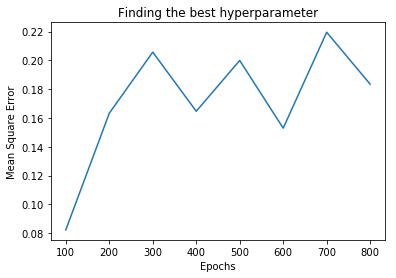

In [38]:
lists = sorted(epochs_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.show()

12.3 Optimal number of neurons